## GOOGLE ANALYTICS CUSTOMER REVENUE PREDICTOR

<h2>1.Business/Real-world Problem</h2>

<h3> 1.1 What is google merchandise store </h3>

<p>
Google Merchandise Store, an ecommerce site that sells Google-branded merchandise like Apparel, lifestyle products, stationary and many more 
<p>

<h3> 1.2 Business Problem statement / Understanding </h3>


- In this competition, we are challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue that can be generated per customer in the future


    
- Marketing team wants to make appropriate investment in promotional strategies for attracting potential custoemrs but many small businesses have only small percentage of customers who generate most of revenue, and hence becomes difficult to predict potential customers and amount of revenue that can generated from those customers in future


<h3> 1.3 Useful Links </h3>

<p>
<b> Source: </b> https://www.kaggle.com/c/ga-customer-revenue-prediction/overview
<p>

<h3> 1.4 Real World business objectives/ constraints </h3>

- no latency constraints
- It is a regression problem 
- the metric we will use is RMSE


`<h2>2.1. Data Overview</h2>

<h3> Source:- https://www.kaggle.com/c/ga-customer-revenue-prediction/data <h3>

Each row in the dataset is one visit to the store. Because we are predicting the log of the total revenue per user

what are we predicting?
- We are predicting the natural log of the sum of all transactions per user.
### Yuser = ∑i =ln(Transaction user)i
### targetuser = ln(Yuser + 1)

#### Data Fields
- fullVisitorId  -   A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date   -          The date on which the user visited the Store.
- device -          The specifications for the device used to access the Store.
- geoNetwork -      This section contains information about the geography of the user.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals -          This section contains aggregate values across the session.
- trafficSource -   This section contains information about the Traffic Source from which the session originated.
- visitId -         An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique - - to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber -     The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime -  The timestamp (expressed as POSIX time).
- hits -            This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions- This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- totals -          This set of columns mostly includes high-level aggregate data.

### other important details on the dataset

###### Source : -https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/65691

- if totals.transactionRevenue is null, then it means that there was no purchase.


- There is a set of features in json, that contain <b>'not available in demo dataset' entries. In particular, ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.criteriaParameters'] </b>contain only this string


- <b>socialEngagementType and totals.visits</b> have a single value only


- we have noticed that for some records the date extracted from visitStartTime do not match the field date.


- trafficSource.campaignCode has a single non-NaN value in the training dataset and the column is completely missing in the test dataset. This is just fun fact :)


- trafficSource.adwordsClickInfo.isVideoAd has only False as a non-NaN value. Does it mean that NaN == True? yes that appears be the case here


-  Since we're predicting the natural log of the sum of the revenue for a particular user, if you believe they've made no purchases, then your final prediction would be zero.


- in practice the evaluation is RMSE on ln(total_Revenue + 1)

### 2.2 IMPORTANT NOTE :
- Due to the formatting of fullVisitorId you must load the Id's as strings in order for all Id's to be properly unique!
- Actually the <b> columns device, geoNetwork, trafficSource, totals </b> contain data in JSON format

### 2.3 FACTS

- The thing is that we also have some revenue data buried deeply inside the infamous Hits field. 
- while doing some consistency checks between these different views on the revenue and it turned out that in the Hits field we have json datasets for each hit, which includes some revenue figures for a transaction if such a hit resulted in a transaction.

- Now, based on at least three examples I can conclude that the field transactionRevenue corresponds only to the revenue resulting from one certain transaction during a visit, whereas totalTransactionRevenue represents the whole revenue resulting from the whole visit. 

- That is why any aggregations of transactionRevenue on the user level represent some (random) fractions of the aggregate user revenue over a certain period of time, and if this is really the case, this number is unfortunately fairly difficult to model and senseless to predict.

In [41]:
import zipfile
with zipfile.ZipFile('train_v2.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import fbprophet
from datetime import datetime, timedelta
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


###  3.1 How to read csv file with json fileds

In [2]:
#https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ['{column}.{subcolumn}'.format(column = column, subcolumn = subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}" .format(os.path.basename(csv_path), df.shape))
    return df

### 3.2 Loading the train and test dataset

In [87]:
%%time
train_df = load_df('train_v2.csv')

Loaded train_v2.csv. Shape: (1708337, 60)
CPU times: user 8min 12s, sys: 21.1 s, total: 8min 34s
Wall time: 10min 11s


In [4]:
%%time
test_df = load_df('test_v2.csv')

Loaded test_v2.csv. Shape: (401589, 59)
CPU times: user 2min 7s, sys: 7.82 s, total: 2min 15s
Wall time: 2min 45s


In [97]:
test_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite',
       'totals.totalTransactionRevenue', 'totals.transactionRevenue',
       'totals.transactions', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSou

In [ ]:
es = open('test_df', 'rb')
test_df = pickle.load(es)

In [ ]:
train_df['fullVisitorId'] = train_df['fullVisitorId'].astype('str')
test_df['fullVisitorId'] = test_df['fullVisitorId'].astype('str')

In [6]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


### 3.3 Getting information on train and test dataset

In [7]:
print(train_df.shape)
print(train_df.info())
print('*'*100)
print(test_df.info())

(1708337, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 60 columns):
channelGrouping                                      object
customDimensions                                     object
date                                                 int64
fullVisitorId                                        object
hits                                                 object
socialEngagementType                                 object
visitId                                              int64
visitNumber                                          int64
visitStartTime                                       int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                      

In [19]:
train_df.isnull().any()

channelGrouping                                      False
customDimensions                                     False
date                                                 False
fullVisitorId                                        False
hits                                                 False
socialEngagementType                                 False
visitId                                              False
visitNumber                                          False
visitStartTime                                       False
device.browser                                       False
device.browserSize                                   False
device.browserVersion                                False
device.deviceCategory                                False
device.flashVersion                                  False
device.isMobile                                      False
device.language                                      False
device.mobileDeviceBranding                          Fal

### Observation
- In the train daset there are 18 columns that have missing value or not available data.
- trafficSource.campaignCode rows that are not present in test data set
- session id is combination of fullvistorid and visitid
- it can be observed that some columns in both train and test data set have <b> 'not available in demo dataset'</b>. and many columns have <b>NaN</b> values.
- so it looks like many columns have a lot of missing data that we need to analyze first.

In [21]:
print('What this tells us is one visitor or customer has visited the store more than once ')
print(train_df['fullVisitorId'].value_counts())
print('*'*50)
#test_df['fullVisitorId'].value_counts()

What this tells us is one visitor or customer has visited the store more than once 
1957458976293878100    400
7282998257608986241    315
3884810646891698298    268
0824839726118485274    258
7477638593794484792    218
                      ... 
0675606548465695554      1
0235824202100862712      1
2023294647430160669      1
4927319884402836916      1
4530882182905818530      1
Name: fullVisitorId, Length: 1323730, dtype: int64
**************************************************


### 4.0 EXPLORATORY DATA ANALYSIS:-


- lets check for features that have a  impact on the revenue generated
- lets check if date, that is month or year or day has any signiifcant impact on the revenue generated
- Also look for customers that have generated revenue to the store
- look for nay missing data in the dataste
- categorical and numerical can be analized seperately.
- most important thing is to analyse the revenue generated by unique customers 
- any feature that has signficant impact on the revenue genration could be useful here.


In [112]:
print('min and max train and test dates')
print(train_df['date'].min(), train_df['date'].max())
print(test_df['date'].min(), test_df['date'].max())

min and max train and test dates
20160801 20180430
20180501 20181015


### 4.1 Train data revenue and visitors analysis

In [6]:
#lets check for customers and the revenue generated by them  train data
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float') 
TR_df = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

Nn_TR= pd.notnull(train_df['totals.transactionRevenue']).sum()
revenue = (TR_df['totals.transactionRevenue']>0).sum()
print('the number of rows in train data with non zero revenue is :', Nn_TR, 'the % of non zero rows to toal rows is ', float(Nn_TR/train_df.shape[0]) *100)
print('the number of unique customers with non zero revenue is :', revenue, 'the % of customers with non zero revenue is ', revenue/ TR_df.shape[0] * 100)

the number of rows in train data with non zero revenue is : 18514 the % of non zero rows to toal rows is  1.0837440153786986
the number of unique customers with non zero revenue is : 16141 the % of customers with non zero revenue is  1.219357421830736


###  4.2 Test data revenue and visitors analysis

In [10]:
#analysing test data transactionrevenue
test_df['totals.transactionRevenue'] = test_df['totals.transactionRevenue'].astype('float')
df_t = test_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
df = df_t[df_t['totals.transactionRevenue']>0]
print('the number of customers with non zero revenue in test data is ', df.shape[0])
print('% of customers with non zero revenue intest data is ', (df.shape[0]/df_t.shape[0])*float(100))

the number of customers with non zero revenue in test data is  4156
% of customers with non zero revenue intest data is  1.401544531750582


In [5]:
#nunique will return the number of unique values : default dropna = True
print('the number of unique visitors in train data set is :', train_df['fullVisitorId'].nunique(), 'out of the total :', train_df.shape[0])
print('the number of unique visitors in test data set is :', test_df['fullVisitorId'].nunique(), 'out of the total :', test_df.shape[0])
print('the common visitor in both train and test data is ', len(set(train_df['fullVisitorId'].unique()).intersection(set(test_df['fullVisitorId'].unique())) ))

the number of unique visitors in train data set is : 1323730 out of the total : 1708337
the number of unique visitors in test data set is : 296530 out of the total : 401589
the common visitor in both train and test data is  2759


### Categorical data

In [7]:
categorical_tr = train_df.select_dtypes(include = [np.object])
categorical_tr.columns

Index(['channelGrouping', 'customDimensions', 'fullVisitorId', 'hits',
       'socialEngagementType', 'device.browser', 'device.browserSize',
       'device.browserVersion', 'device.deviceCategory', 'device.flashVersion',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite',
       'totals.totalTransactionRevenue',

In [8]:
categorical_test = test_df.select_dtypes(include = [np.object])
categorical_test.columns

Index(['channelGrouping', 'customDimensions', 'fullVisitorId', 'hits',
       'socialEngagementType', 'device.browser', 'device.browserSize',
       'device.browserVersion', 'device.deviceCategory', 'device.flashVersion',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite',
       'totals.totalTransactionRevenue',

### 4.3 Data Preprocessing

- as we have already observed that some columns have 'not available in demo dateset ' we can safely remove thses columns as they wont effect our model prediction  so we can safely remove such columns

In [ ]:
print('the number of columns before removing the useless features', train_df.shape[1], test_df.shape[1])

train_df = train_df.loc[ : , (train_df != train_df.iloc[0]).any()]  # here we are considering only those columns who are satisfying the condition that is if the rows in a column are not equal to first row value it will return true , so we are only considering those that return true and negelecting the columns that return false that means that column has all the same values/ categories, if column has all the same values it will retuen false , even a single value is true will return true

test_df = test_df.loc[:, (test_df != test_df.iloc[0]).any()] # taking those columns that doesnot have constant values

print('the number of columns in train and test data set after removing useless features', train_df.shape[1], test_df.shape[1])

#### 4.3.1 Removing columns with only one value, totals.new_visits and totals.bounce have only one value

In [ ]:
train_df.drop(['totals.newVisits', 'totals.bounces'], axis = 1, inplace = True)
test_df.drop(['totals.newVisits', 'totals.bounces'], axis = 1, inplace = True)
print(train_df.shape)
print(test_df.shape)

### 4.4 Visualizing missing values

### 4.4.1 Train data visualization

In [8]:
missing_cat_df = categorical_tr.isnull().sum().sort_values(ascending = False) #gives the sum of missing values for each column
percentage_miss = (categorical_tr.isnull().sum()/categorical_tr.shape[0]).sort_values(ascending = False)*100
data_miss = pd.concat([missing_cat_df, percentage_miss], axis =1, keys = ['Total missing count', '% of total missing'])
data_miss.index.name = 'Feature'
data_miss.head(20)

,Total missing count,% of taotal missing
Feature,,
trafficSource.campaignCode,1708336,99.999941
totals.totalTransactionRevenue,1689823,98.916256
totals.transactionRevenue,1689823,98.916256
totals.transactions,1689778,98.913622
trafficSource.adContent,1643600,96.210525
trafficSource.adwordsClickInfo.adNetworkType,1633063,95.593727
trafficSource.adwordsClickInfo.slot,1633063,95.593727
trafficSource.adwordsClickInfo.page,1633063,95.593727
trafficSource.adwordsClickInfo.isVideoAd,1633063,95.593727


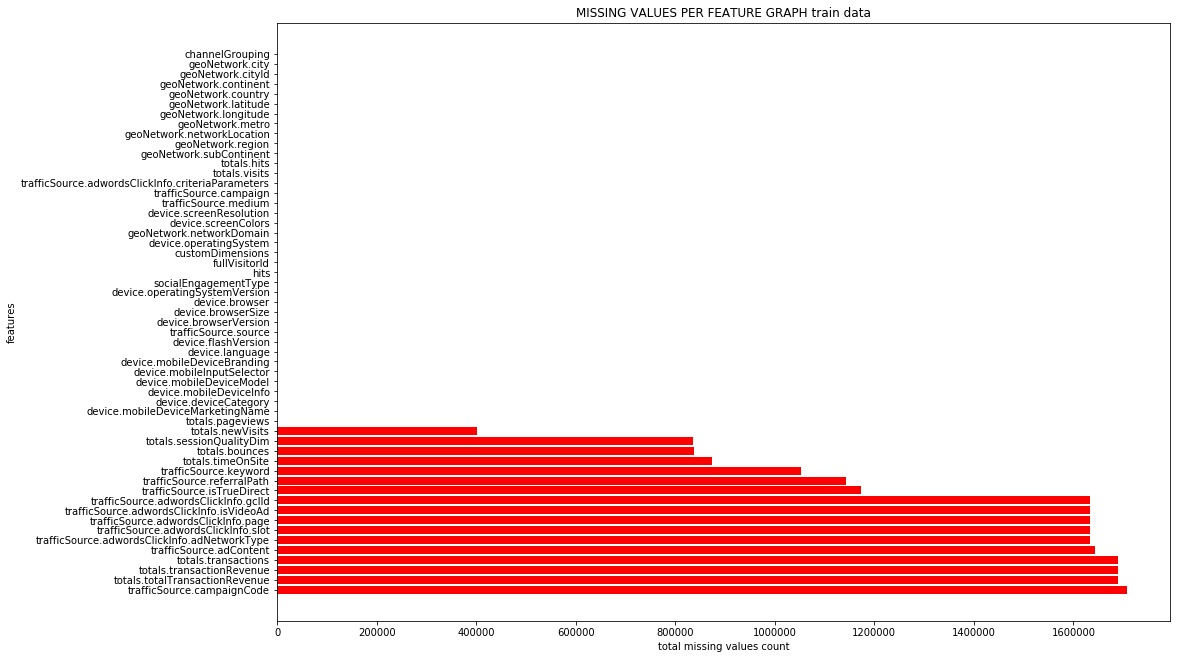

In [40]:
ind = np.arange(55)
#plot for visualizing
plt.figure(figsize=(16,11))
plt.barh(ind, data_miss['Total missing count'].values, color = 'r')
plt.yticks(ind, missing_cat_df.keys())
plt.xlabel('total missing values count')
plt.ylabel('features')
plt.title('MISSING VALUES PER FEATURE GRAPH train data')
plt.show()

### 4.4.2 test data visualization 

In [44]:
missing_cat_test = categorical_test.isnull().sum(axis = 0).sort_values(ascending = False)
mis_test_perc = (categorical_test.isnull().sum(axis = 0)/ categorical_test.shape[0]).sort_values(ascending = False)*100
test_data_miss = pd.concat([missing_cat_test, mis_test_perc], axis = 1, keys = ['total missing count', '% of total missing'])
test_data_miss.index.name = 'Feature'
test_data_miss.head(20)

,total missing count,% of total missing
Feature,,
totals.totalTransactionRevenue,396995,98.856044
totals.transactionRevenue,396995,98.856044
totals.transactions,395284,98.429987
trafficSource.adwordsClickInfo.adNetworkType,390984,97.359240
trafficSource.adwordsClickInfo.slot,390984,97.359240
trafficSource.adwordsClickInfo.page,390984,97.359240
trafficSource.adwordsClickInfo.isVideoAd,390984,97.359240
trafficSource.adwordsClickInfo.gclId,390977,97.357497
trafficSource.isTrueDirect,253180,63.044556


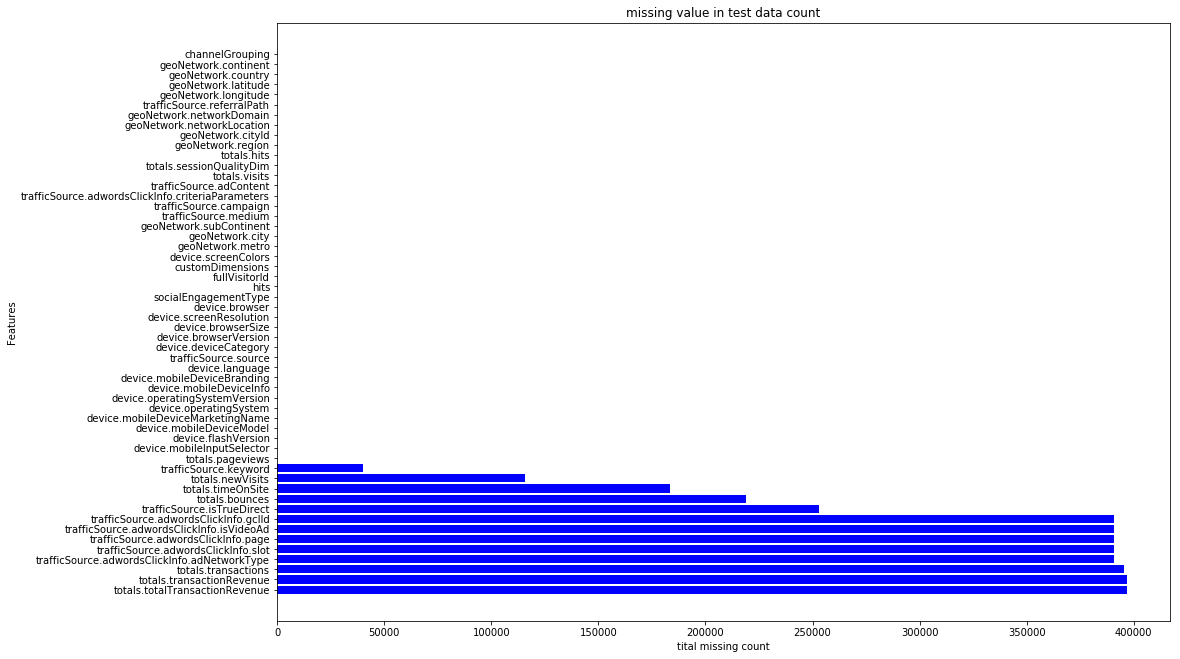

In [46]:
ind = np.arange(len(categorical_test.columns))
plt.figure(figsize = (16, 11))
plt.barh(ind, test_data_miss['total missing count'].values, color = 'b')
plt.yticks(ind, missing_cat_test.keys())
plt.xlabel('tital missing count')
plt.ylabel('Features')
plt.title('missing value in test data count')
plt.show()

### 4.4.3 Lets look at correlation between our features first

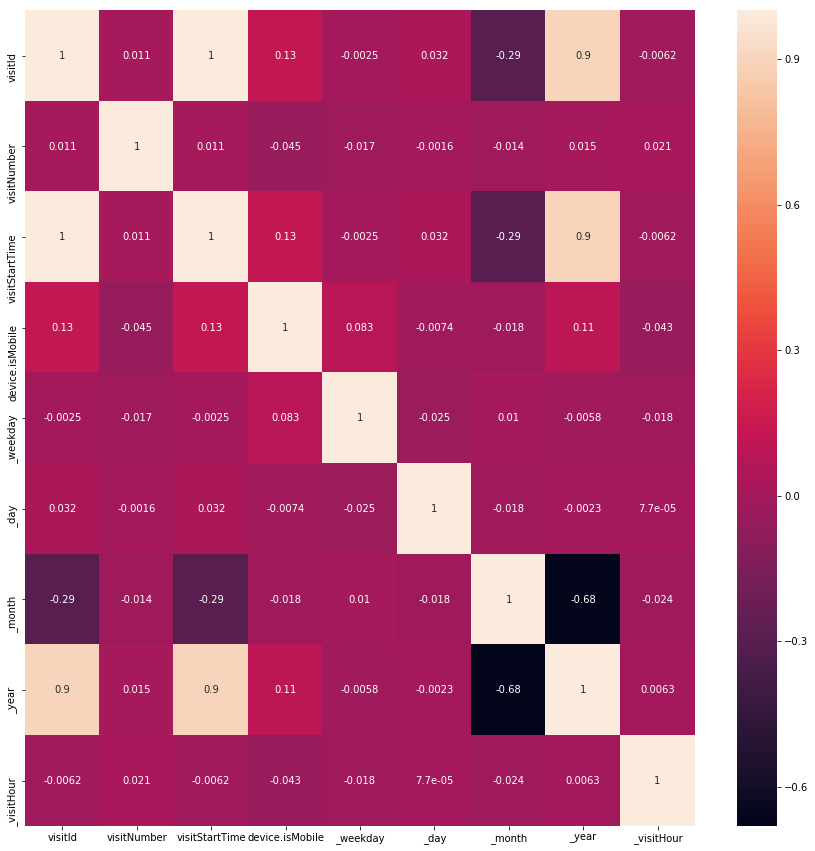

In [54]:
### correlation 
corrmat = train_df.corr()
top_cor_features = corrmat.index
plt.figure(figsize=(15,15))

#print(heat map)
g = sns.heatmap(train_df[top_cor_features].corr(), annot = True)


<b> - Not very informative/useful 
    - there is some relation between device ismobile and year and device ismobile an visitstrat time

### 4.4 Performing analysis on features to get some insights

### 4.4.1 Transcation reveune wih respect to full visitor id 

In [9]:
train_df['totals.totalTransactionRevenue'].fillna(0, inplace = True) #replacing the nan wityh 0 in transaction revenue
train_df['totals.transactionRevenue'] = train_df['totals.totalTransactionRevenue'].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

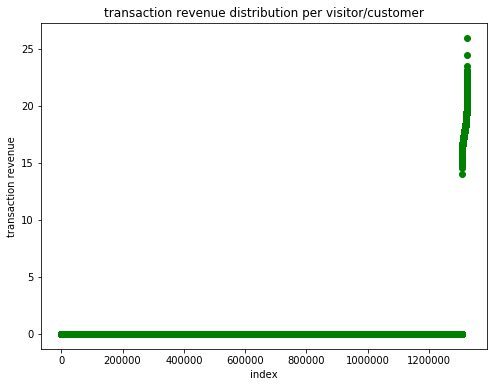

In [10]:
plt.figure(figsize=(8,6))
ind = range(gdf.shape[0])
plt.scatter(ind, np.sort(np.log1p(gdf['totals.transactionRevenue'].values)), c = 'g')
plt.title('transaction revenue distribution per visitor/customer')
plt.xlabel('index')
plt.ylabel('transaction revenue')
plt.show()

Observation:-

- there are many customers that have generated very few revenue where as there are very few customers that have generated lot of revenue for the Gstore.

- there is one point in the graph that has a very high transaction value which might or might not be an outlier.
- As we have already seen that the ratio of revenue generating customers is 1.2193 %

### 4.3.2 Considering only non zero transaction revenue:-

In [8]:
non_zero = train_df[train_df['totals.transactionRevenue'] > 0]['totals.transactionRevenue']
non_zero.describe()

count    1.851400e+04
mean     1.428167e+08
std      6.455644e+08
min      1.200000e+06
25%      2.896000e+07
50%      5.279000e+07
75%      1.089675e+08
max      4.708206e+10
Name: totals.transactionRevenue, dtype: float64

Text(0.5, 1.0, ' Non Zero transaction revenue PDF')

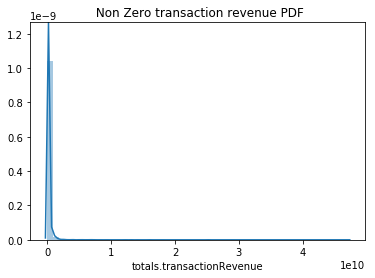

In [67]:
sns.distplot(non_zero)
plt.title(' Non Zero transaction revenue PDF')

In [11]:
# since the submission is in log of sum of revenue per customer lets apply log on the transaction column 
#https://www.geeksforgeeks.org/numpy-log1p-python/
rev_log = train_df['totals.totalTransactionRevenue'].astype('float').apply(np.log1p)
rev_log[rev_log > 0].head()


433    16.659838
550    16.380460
555    17.994503
597    17.043544
619    16.607289
Name: totals.totalTransactionRevenue, dtype: float64

count    18514.000000
mean        17.941181
std          1.082744
min         13.997833
25%         17.181426
50%         17.781832
75%         18.506560
max         24.575158
Name: totals.totalTransactionRevenue, dtype: float64


Text(0.5, 1.0, 'log revenue > 0')

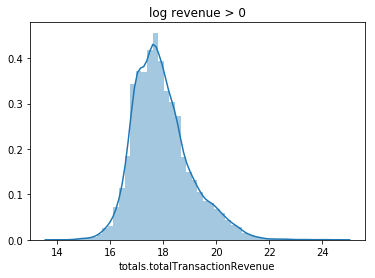

In [12]:
print((rev_log[rev_log>0]).describe())
plt.figure()
sns.distplot(rev_log[rev_log > 0])
plt.title('log revenue > 0')

<b> Observation :-
- the target variable has wide range of values its distribution is right skewed. For modelling we will use log transformed target
- as we have already seen that only 1.219% of all transactions gave non zero revenue.
- the mean of log revenue distribution is 17.9 (important info)

### 4.3.3 ANALYSING DATE AND VISIT START TIME

In [ ]:
# https://docs.python.org/3/library/datetime.html
#https://stackoverflow.com/questions/42514963/how-to-convert-visit-start-time-to-a-readable-human-date-or-timestamp-in-big-que
from datetime import datetime
def date_feature(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting month
    df["_year"] = df['date'].dt.year # extracting year
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int) #instaed of this we could also use (pd.datetime(df['visitstarttime'], unit = 's').dt.hour
    return df #returning the df after the transformations

In [ ]:
train_df = date_feature(train_df)
test_df = date_feature(test_df)

In [ ]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

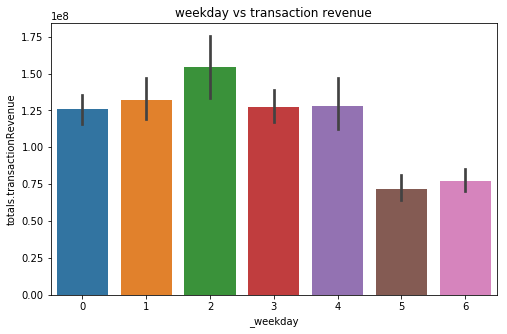

In [20]:
plt.figure(figsize=(8,5))
sns.barplot(train_df['_weekday'], train_df['totals.transactionRevenue'].astype('float'), data = train_df )
plt.title('weekday vs transaction revenue')
plt.show()

#### Observation :
- 0 is monday 
- 6 is sunday
- on weekdays there looks to be more sales comparatively

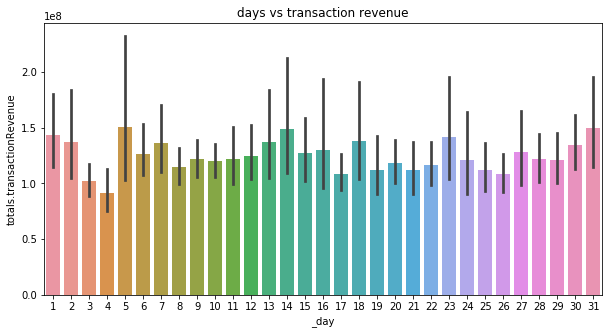

In [22]:
#lets look at the days of each month:-
plt.figure(figsize=(10,5))
sns.barplot(train_df['_day'], train_df['totals.transactionRevenue'].astype('float'), data = train_df)
plt.title('days vs transaction revenue')
plt.show()

- <b> starting days , middle days and ending days of a month looks to have slightly higher sales 

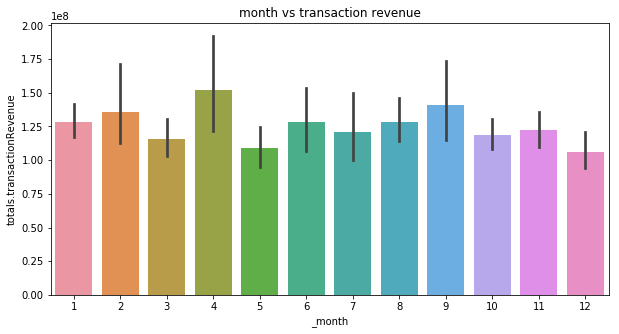

In [24]:
#lets look at the month:-
plt.figure(figsize=(10,5))
sns.barplot(train_df['_month'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('month vs transaction revenue')
plt.show()

- <b> sales in 4th, 9th month is highest , does not apper to have a seasonality trend here.

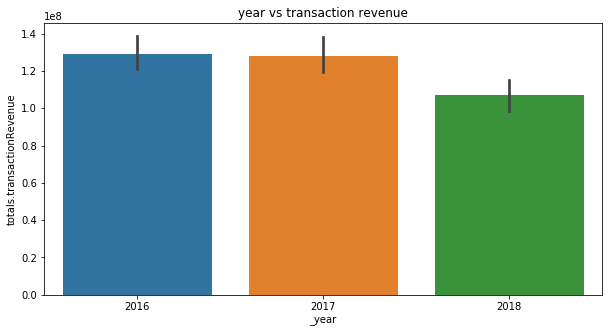

In [25]:
#lets look at year
#lets look at the days of each month:-
plt.figure(figsize=(10,5))
sns.barplot(train_df['_year'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('year vs transaction revenue')
plt.show()

 - <b> clearly sales have decreased in 2018 when compared to previous years 

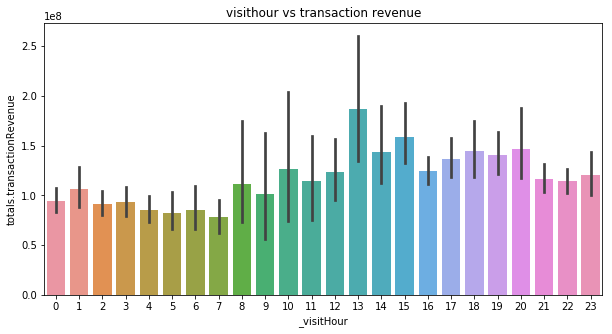

In [26]:
#lets look at visit hour: which is the visit start time in hour
plt.figure(figsize=(10,5))
sns.barplot(train_df['_visitHour'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('visithour vs transaction revenue')
plt.show()

- <b> visit hour is an interesting feature as late hours have more transaction revenue than early hours

### 4.3.4 HOW TARGET VARIABLE CHANGE WITH TIME

### 4.3.4.1 Transaction revenue with respect to date 

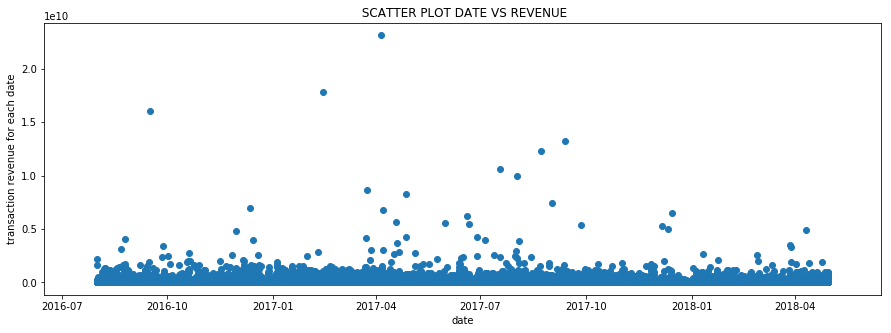

In [33]:
plt.figure(figsize=(15,5))
plt.scatter(train_df['date'], train_df['totals.transactionRevenue'])
plt.xlabel('date')
plt.ylabel('transaction revenue for each date')
plt.title(' SCATTER PLOT DATE VS REVENUE')
plt.show()

In [80]:
### How does revenue changes with date
da_df = train_df.groupby('date')['totals.transactionRevenue'].sum().reset_index() 
da_df = da_df.set_index('date')
da_df

,totals.transactionRevenue
date,
2016-08-01,6.116060e+09
2016-08-02,1.361190e+09
2016-08-03,0.000000e+00
2016-08-04,1.182890e+09
2016-08-05,5.594260e+09
...,...
2018-04-26,3.112580e+09
2018-04-27,2.415980e+09
2018-04-28,3.872800e+08


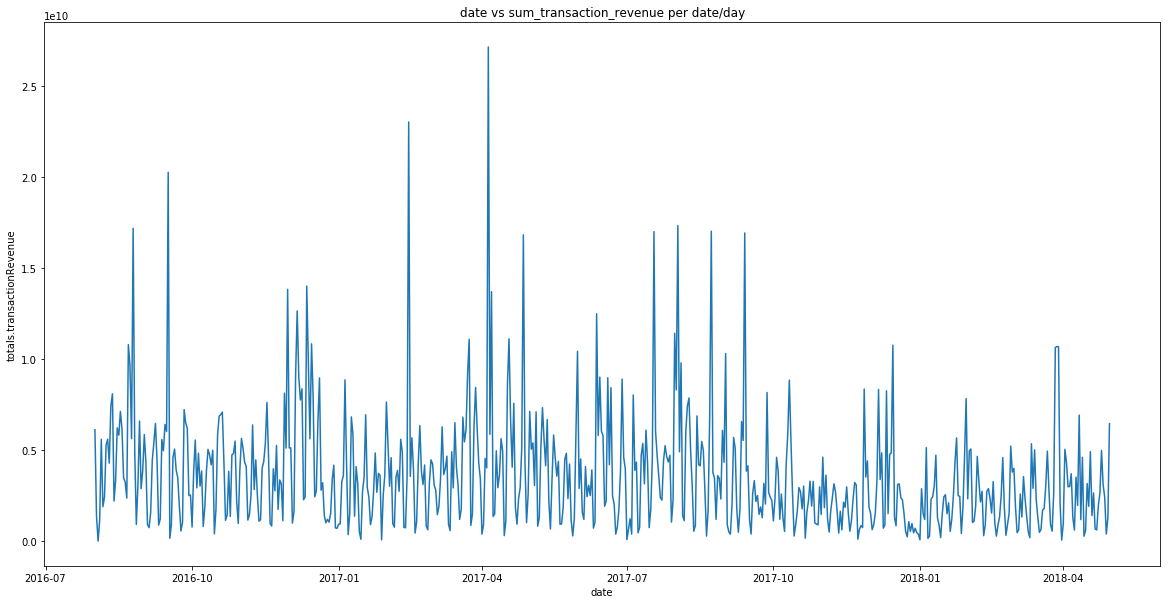

In [105]:
plt.figure(figsize=(20,10))
sns.lineplot(da_df['date'], da_df['totals.transactionRevenue'])
plt.title('date vs sum_transaction_revenue per date/day')
plt.show()

- <b> the revenue can be viewed as a time series as there seems to be a pattern here

### 4.3.5 lets look at how many number of users were present at that particular date

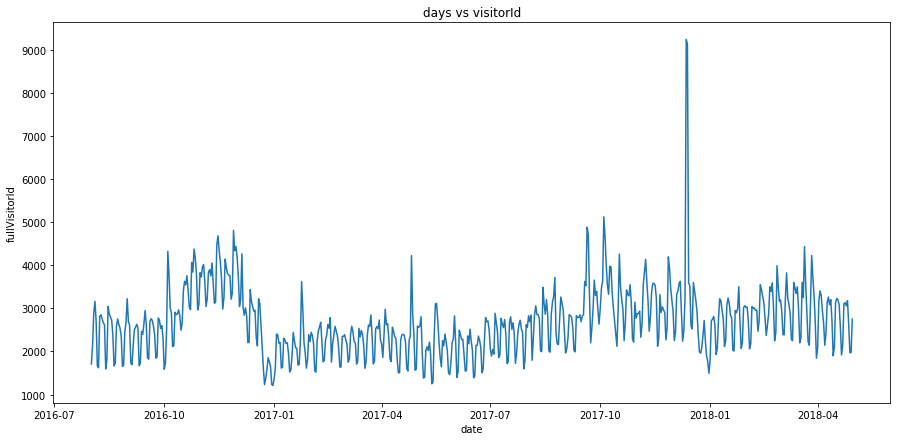

In [27]:
user_count_df = train_df.groupby('date')['fullVisitorId'].size().reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(user_count_df['date'], user_count_df['fullVisitorId'], markers= True)
plt.title('days vs visitorId')
plt.show()

### 4.3.5.1 visit number vs date

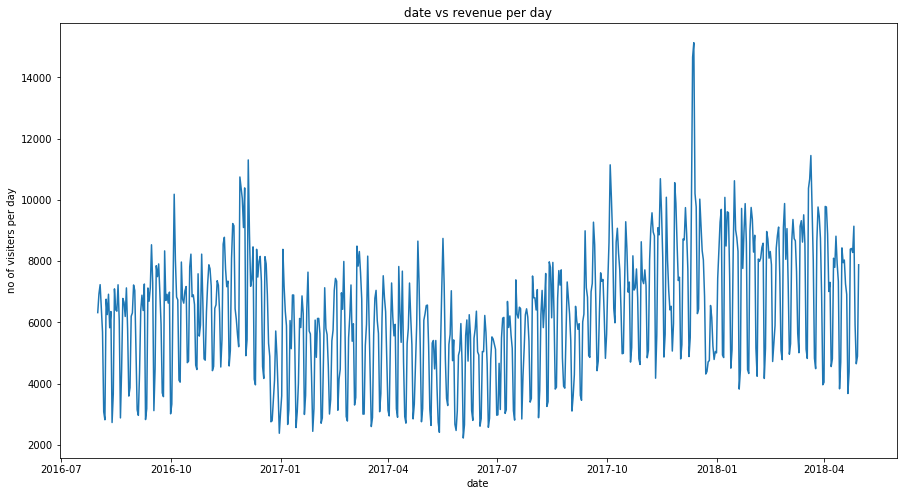

In [28]:
visit_df = train_df.groupby('date')['visitNumber'].agg(['sum']).reset_index()
plt.figure(figsize=(15, 8))
sns.lineplot(visit_df['date'], visit_df['sum'])
plt.ylabel('no of visiters per day')
plt.title('date vs revenue per day')
plt.show()

### <b> - looking if there a relationship between number of visitors per day and transaction revenue per day??

Note:- above both the graphs are the same 

In [6]:
#### function to extract sub feature of a feature column
import re
def feat_extract(category):
    cat_lst = []
    for i in train_df.columns:
        c = re.findall(r'^' + category +'.*', i )
        if c:
            cat_lst.extend(c)
        else:
            continue    
    return cat_lst

In [42]:
# difference between size and count:- size includes NaN values, count does not:
def plt_categories(df, col):
    df1 = df.loc[:, [col, 'totals.transactionRevenue']]
    df1['totals.transactionRevenue'] = df1['totals.transactionRevenue'].astype('float')
    df1 = df1.groupby(col)['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
    df1.columns = ['count', 'revenue count', 'avg revenue']
    df1['total_revenue_sum'] = df1['revenue count']* df1['avg revenue']
    df1 = df1.sort_values(by = 'count', ascending = False)
    print(df1.head(10))
    
    plt.figure(figsize=(10,20))
    plt.subplot(4, 1, 1)
    sns.barplot(df1['count'].head(10), df1.index[:10] )
    
    plt.subplot(4,1,2)
    sns.barplot(df1['revenue count'].head(10), df1.index[:10])
    
    plt.subplot(4,1,3)
    sns.barplot(df1['avg revenue'].head(10), df1.index[:10])
    
    plt.subplot(4,1,4)
    sns.barplot(df1['total_revenue_sum'].head(10), df1.index[:10])
    
    print('*'*50)

### 4.6 Geo Network category EDA

In [20]:
geonetwork_cols = feat_extract('geoNetwork')
geonetwork_cols

['geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent']

### 4.6.1 geonetwork continent

                       count  revenue count   avg revenue  total_revenue_sum
geoNetwork.continent                                                        
Americas              877403          18150  1.247988e+08       2.265098e+12
Asia                  396719            190  1.231459e+08       2.339772e+10
Europe                368037            126  8.926548e+07       1.124745e+10
Africa                 35481             12  7.521658e+08       9.025990e+09
Oceania                28180             29  2.338310e+08       6.781100e+09
(not set)               2517              7  1.136029e+08       7.952200e+08
**************************************************


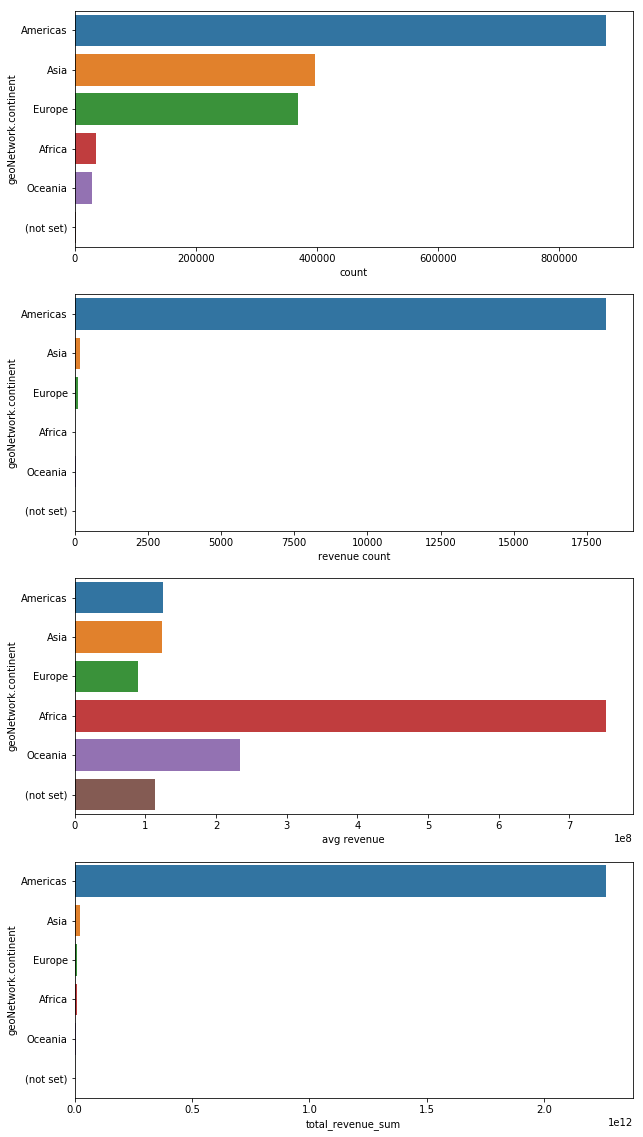

In [21]:
plt_categories(train_df, 'geoNetwork.continent')

- <b> the revenue generated from America is much larger than any other continent
- <b> though we have more customers from asia  and eutope also but the revenue generated from them is very less

### 4.6.2 geonetwork country

                     count  revenue count   avg revenue  total_revenue_sum
geoNetwork.country                                                        
United States       717217          17658  1.244697e+08       2.197885e+12
India               105317             18  7.425056e+07       1.336510e+09
United Kingdom       73341             25  9.900160e+07       2.475040e+09
Canada               51057            315  1.355531e+08       4.269923e+10
Germany              38516             12  6.402000e+07       7.682400e+08
Japan                36637             22  3.346136e+08       7.361500e+09
Brazil               35432             21  9.631952e+07       2.022710e+09
Vietnam              34869              0           NaN                NaN
France               32289             11  9.733545e+07       1.070690e+09
Thailand             29859             10  6.141600e+07       6.141600e+08
**************************************************


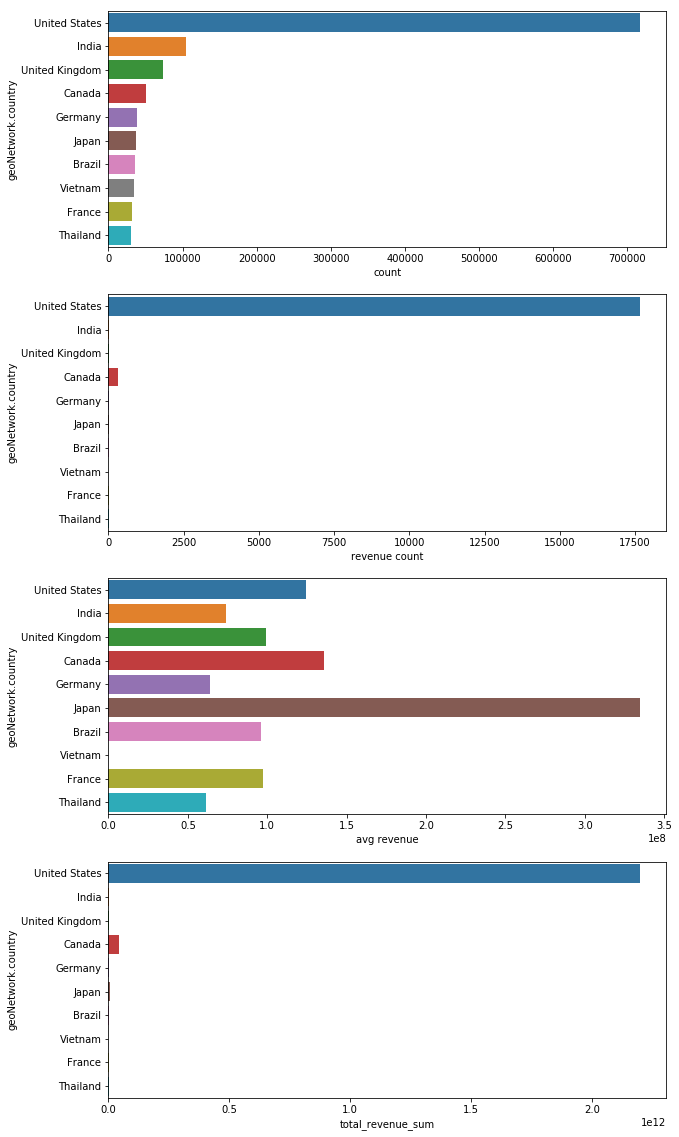

In [22]:
plt_categories(train_df, 'geoNetwork.country')

- <b> most of revenue is generated from united states
- <b> next revenue generating country would be canada

### 4.6.3 geonetwork. subcontinent

                     count  revenue count   avg revenue  total_revenue_sum
geoNetwork.country                                                        
United States       717217          17658  1.244697e+08       2.197885e+12
India               105317             18  7.425056e+07       1.336510e+09
United Kingdom       73341             25  9.900160e+07       2.475040e+09
Canada               51057            315  1.355531e+08       4.269923e+10
Germany              38516             12  6.402000e+07       7.682400e+08
Japan                36637             22  3.346136e+08       7.361500e+09
Brazil               35432             21  9.631952e+07       2.022710e+09
Vietnam              34869              0           NaN                NaN
France               32289             11  9.733545e+07       1.070690e+09
Thailand             29859             10  6.141600e+07       6.141600e+08
**************************************************


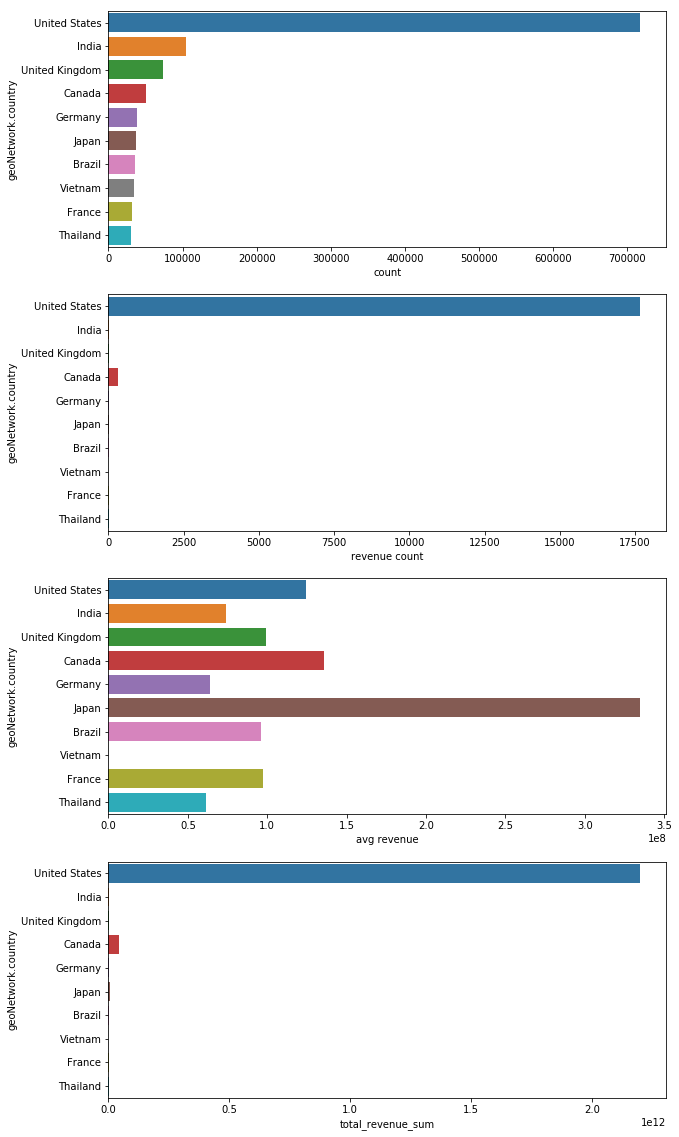

In [23]:
plt_categories(train_df, 'geoNetwork.country')

- <b> same results as continent

#### 4.7 ANALYSING TOTALS CATEGORY

In [35]:
# difference between size and count:- size includes NaN values, count does not:
def plt_categories1(df, col):
    df1 = df.loc[:, [col, 'totals.transactionRevenue']]
    df1['totals.transactionRevenue'] = df1['totals.transactionRevenue'].astype('float')
    df1 = df1.groupby(col)['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
    df1.columns = ['count', 'revenue count', 'avg revenue']
    df1['total_revenue_sum'] = df1['revenue count']* df1['avg revenue']
    df1 = df1.sort_values(by = 'count', ascending = False)
    print(df1.head(10))
    
    plt.figure(figsize=(10,20))
    plt.subplot(4, 1, 1)
    sns.barplot(y = df1['count'].head(50), x = list(range(1,51)) )
    plt.xlabel(col)
    plt.title(col + 'vs count')
    
    plt.subplot(4,1,2)
    sns.barplot(y = df1['revenue count'].head(50), x = list(range(1,51)))
    plt.xlabel(col)
    plt.title(col + 'vs revenue_count')

    plt.subplot(4,1,3)
    sns.barplot(y = df1['avg revenue'].head(50), x = list(range(1,51)))
    plt.xlabel(col)
    plt.title(col + 'vs avg revenue')
    
    plt.subplot(4,1,4)
    sns.barplot(y = df1['total_revenue_sum'].head(50), x = list(range(1,51)))
    plt.xlabel(col)
    plt.title(col + 'vs total_revenue_sum')
    
    print('*'*50)

### 4.7.1 Total hits:-

- <b> The term “hit” is perhaps the most misused term in online marketing, mistakenly used to mean unique visitors, visits, page views, or all of the above. A hit is merely a request for a file from a Web server. 

- <b> A request for a Web page counts as a hit, but so does a request for a graphic on a Web page.

              count  revenue count   avg revenue  total_revenue_sum
totals.hits                                                        
1            864064              0           NaN                NaN
2            237499              7  2.201214e+08       1.540850e+09
3            134435              6  7.817833e+07       4.690700e+08
4             80875             15  8.806667e+07       1.321000e+09
5             63687             27  1.187667e+08       3.206700e+09
6             46598             26  3.551731e+07       9.234500e+08
7             38137             54  5.201111e+07       2.808600e+09
8             29717            107  7.241710e+07       7.748630e+09
9             24999            166  9.122886e+07       1.514399e+10
10            20306            231  9.973732e+07       2.303932e+10
**************************************************


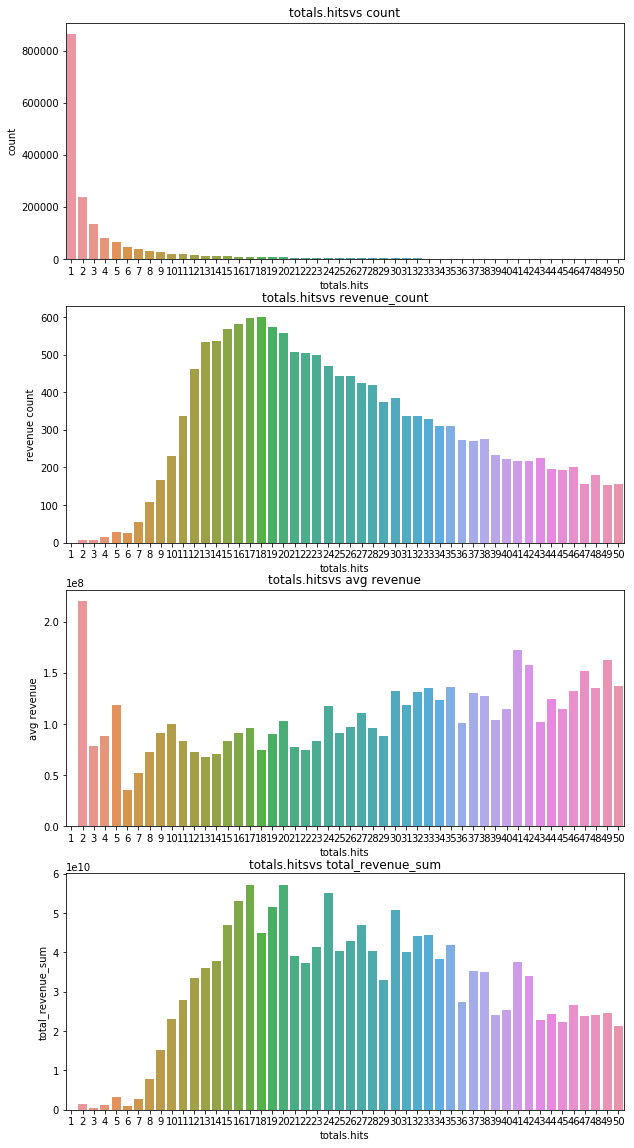

In [36]:
plt_categories1(train_df,'totals.hits' )

### 4.7.2 pageview :

- It is the instance of page being loaded in the browser

                   count  revenue count   avg revenue  total_revenue_sum
totals.pageviews                                                        
1                 876328              0           NaN                NaN
2                 249794              7  2.201214e+08       1.540850e+09
3                 142896              6  7.817833e+07       4.690700e+08
4                  86666             16  8.841688e+07       1.414670e+09
5                  64712             33  1.123712e+08       3.708250e+09
6                  47721             47  4.052234e+07       1.904550e+09
7                  37751             94  4.390862e+07       4.127410e+09
8                  29586            190  8.269163e+07       1.571141e+10
9                  24153            306  8.530141e+07       2.610223e+10
10                 19228            463  7.950987e+07       3.681307e+10
**************************************************


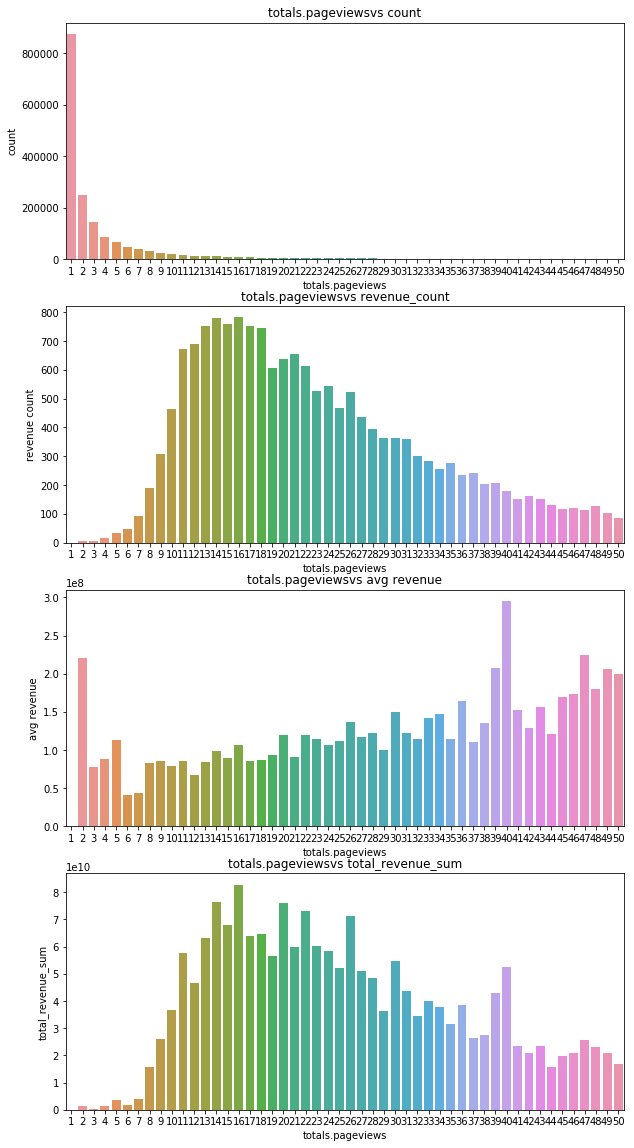

In [37]:
plt_categories1(train_df,'totals.pageviews' )

- <b> very clearly as the page views increases the revenue generation also has increased

### 4.7.3 Time on site:-

- The time spent on a webpage/site

                   count  revenue count  avg revenue  total_revenue_sum
totals.timeOnSite                                                      
5                   9862              0          NaN                NaN
4                   9738              0          NaN                NaN
6                   9150              0          NaN                NaN
7                   8221              0          NaN                NaN
8                   8123              0          NaN                NaN
10                  8117              0          NaN                NaN
9                   8114              1   98330000.0         98330000.0
11                  7975              0          NaN                NaN
12                  7935              0          NaN                NaN
51                  7771              0          NaN                NaN
**************************************************


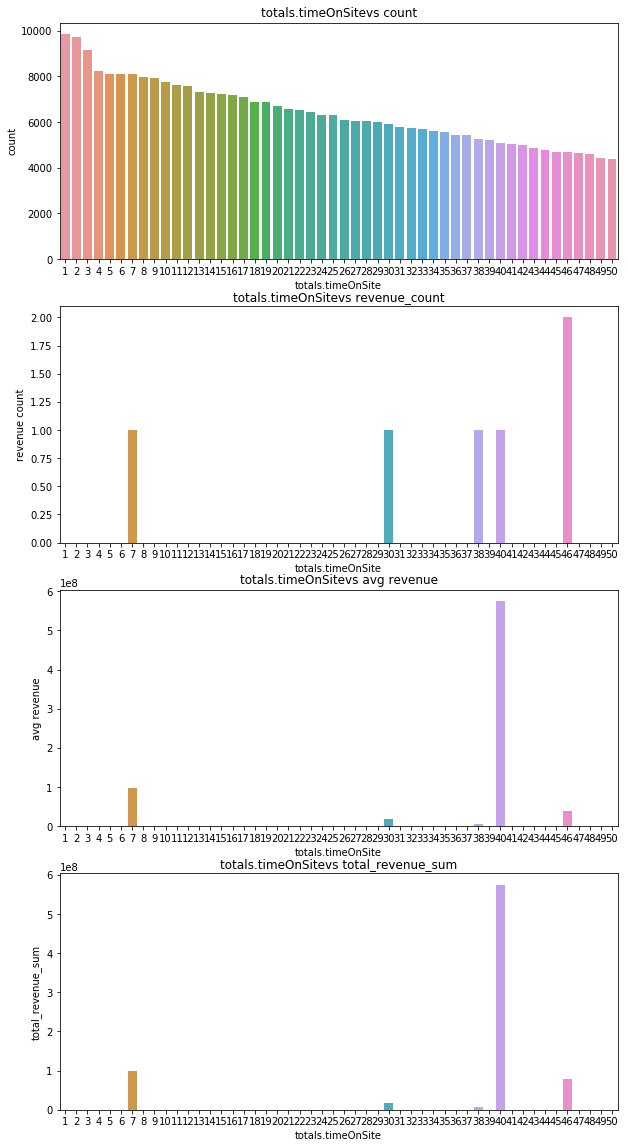

In [39]:
plt_categories1(train_df,'totals.timeOnSite' )

- <b> time on site doesnot give any proper information here

### 4.7.4 Traffic source category EDA

                       count  revenue count   avg revenue  total_revenue_sum
trafficSource.source                                                        
google                658384           4683  1.001894e+08       4.691871e+11
(direct)              565975          13144  1.282169e+08       1.685283e+12
youtube.com           329450             25  2.337640e+07       5.844100e+08
analytics.google.com   37436              3  7.823333e+06       2.347000e+07
Partners               32931             17  5.088647e+07       8.650700e+08
sites.google.com        9072             76  9.024539e+07       6.858650e+09
google.com              8341             14  5.175500e+07       7.245700e+08
m.facebook.com          6737              7  2.825571e+07       1.977900e+08
dfa                     6704            137  7.353030e+08       1.007365e+11
baidu                   4971              0           NaN                NaN
**************************************************


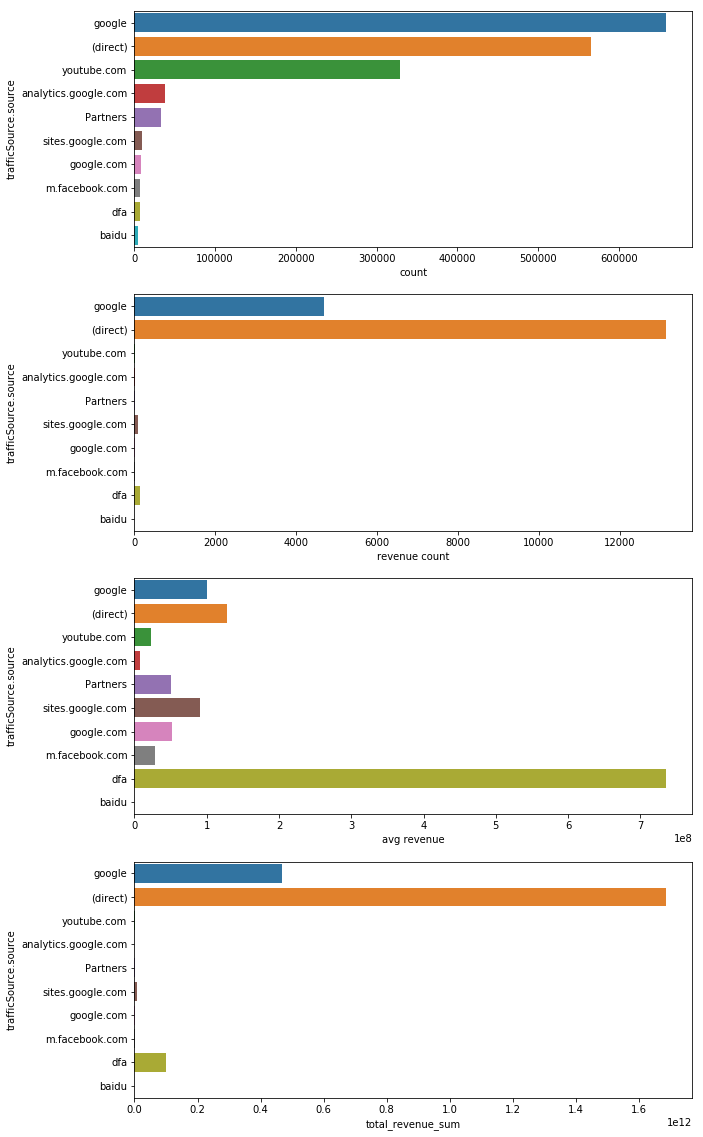

In [43]:
plt_categories(train_df, 'trafficSource.source')

- <b> more trafiic and revenue is generated from Direct and google medium

                       count  revenue count   avg revenue  total_revenue_sum
trafficSource.medium                                                        
organic               591783           4196  9.962047e+07       4.180075e+11
(none)                565957          13144  1.282169e+08       1.685283e+12
referral              432963            468  1.183178e+08       5.537271e+10
cpc                    75603            490  9.941222e+07       4.871199e+10
affiliate              32915             17  5.088647e+07       8.650700e+08
cpm                     8982            198  5.459317e+08       1.080945e+11
(not set)                134              1  9.990000e+06       9.990000e+06
**************************************************


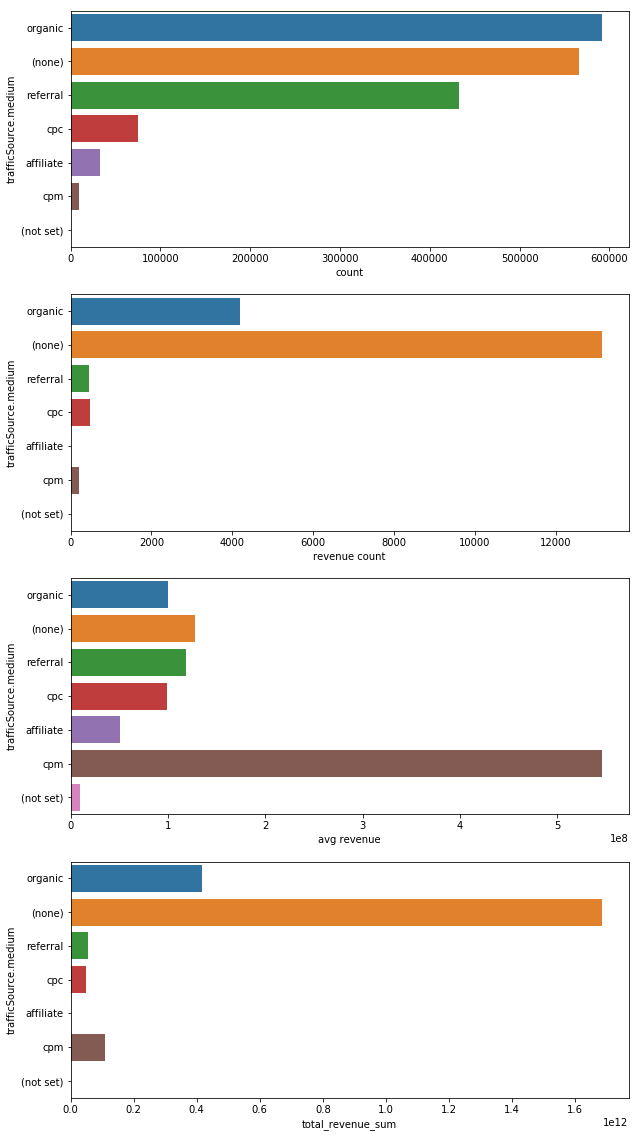

In [81]:
plt_categories1(train_df, 'trafficSource.medium')

### 4.8 Device category:-

### 4.8.1 device browser

                     count  revenue count   avg revenue  total_revenue_sum
device.browser                                                            
Chrome             1173056          16697  1.238645e+08       2.068165e+12
Safari              312165           1210  6.338925e+07       7.670099e+10
Firefox              63845            339  4.432043e+08       1.502462e+11
Internet Explorer    35474            148  8.079703e+07       1.195796e+10
Android Webview      34266             10  1.861100e+07       1.861100e+08
Edge                 20543             74  1.090176e+08       8.067300e+09
Samsung Internet     15792              8  2.760625e+07       2.208500e+08
Opera Mini           15018              0           NaN                NaN
Safari (in-app)      14207             12  1.281417e+07       1.537700e+08
Opera                 9585             14  4.248357e+07       5.947700e+08
**************************************************


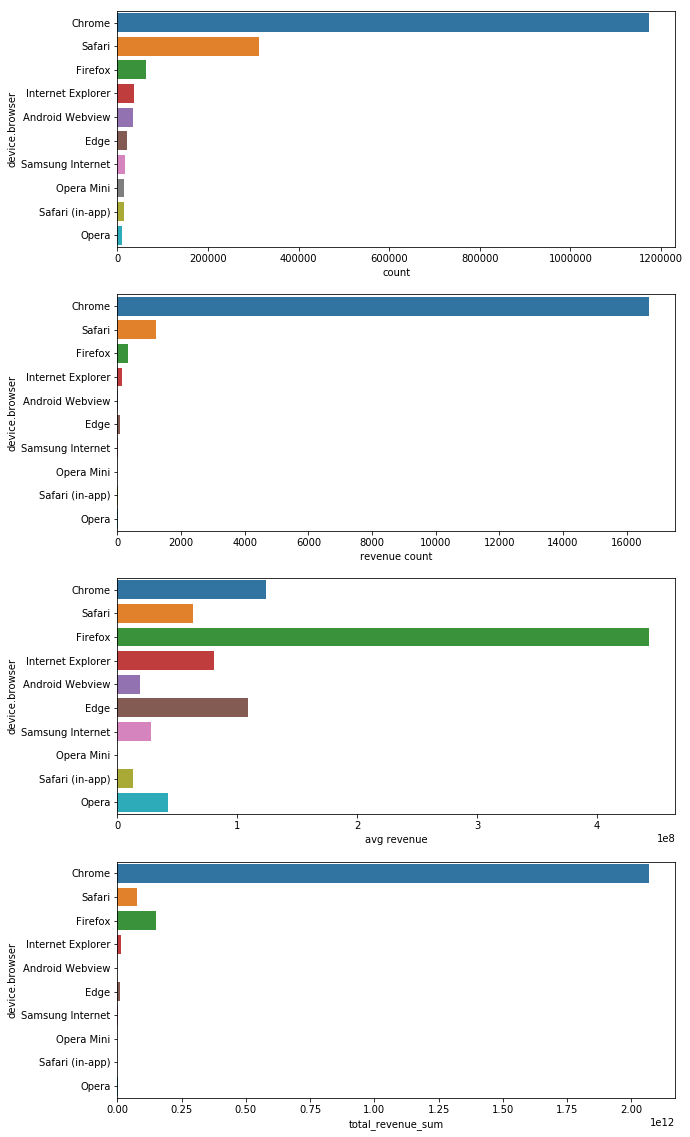

In [82]:
plt_categories(train_df, 'device.browser')

- <b> users with chrome browser have generated more revenue
- mean revenue generation is more for firefox and edge
- users for firefox is less but avg revenue generated is more 

### 4.8.2 device category

                         count  revenue count   avg revenue  total_revenue_sum
device.deviceCategory                                                         
desktop                1171579          16905  1.318602e+08       2.229097e+12
mobile                  471336           1364  5.447116e+07       7.429866e+10
tablet                   65422            245  5.285339e+07       1.294908e+10
**************************************************


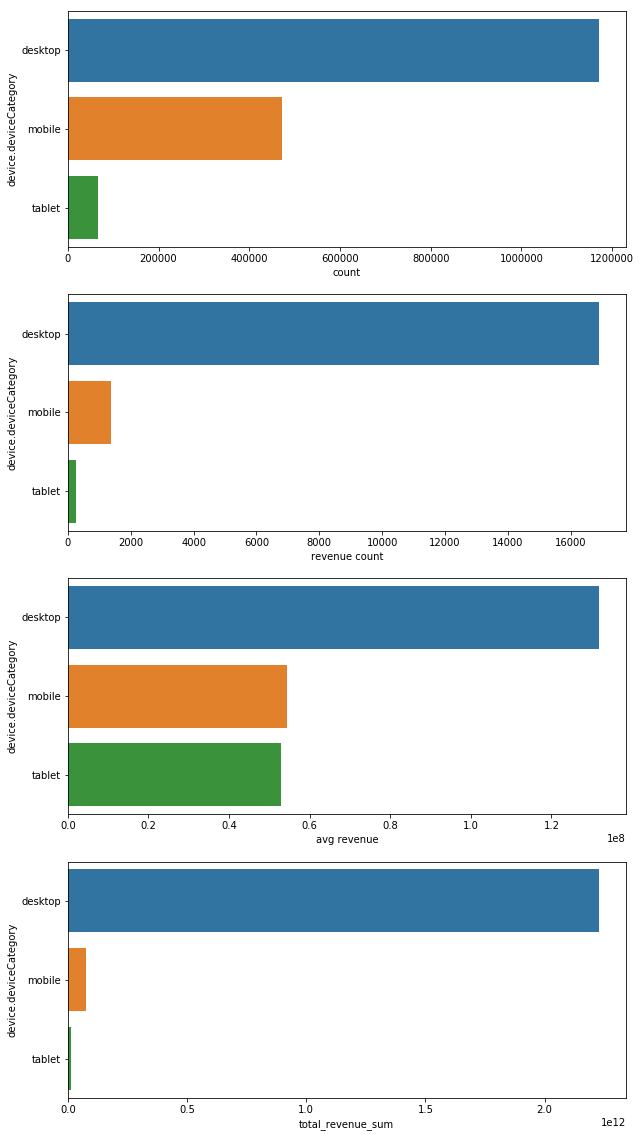

In [84]:
plt_categories(train_df, 'device.deviceCategory')

- <b>desktop  dominates when it comes to generating revenue

### 4.8.3 device operating system

                         count  revenue count   avg revenue  total_revenue_sum
device.operatingSystem                                                        
Windows                 619720           3571  1.610381e+08       5.750670e+11
Macintosh               438514          10354  1.270264e+08       1.315231e+12
Android                 299386            753  6.670659e+07       5.023006e+10
iOS                     219334            832  4.312514e+07       3.588012e+10
Linux                    63971           1300  5.404468e+07       7.025809e+10
Chrome OS                51318           1703  1.583395e+08       2.696522e+11
(not set)                11815              0           NaN                NaN
Windows Phone             1675              1  2.640000e+07       2.640000e+07
Samsung                    911              0           NaN                NaN
Tizen                      709              0           NaN                NaN
**************************************************


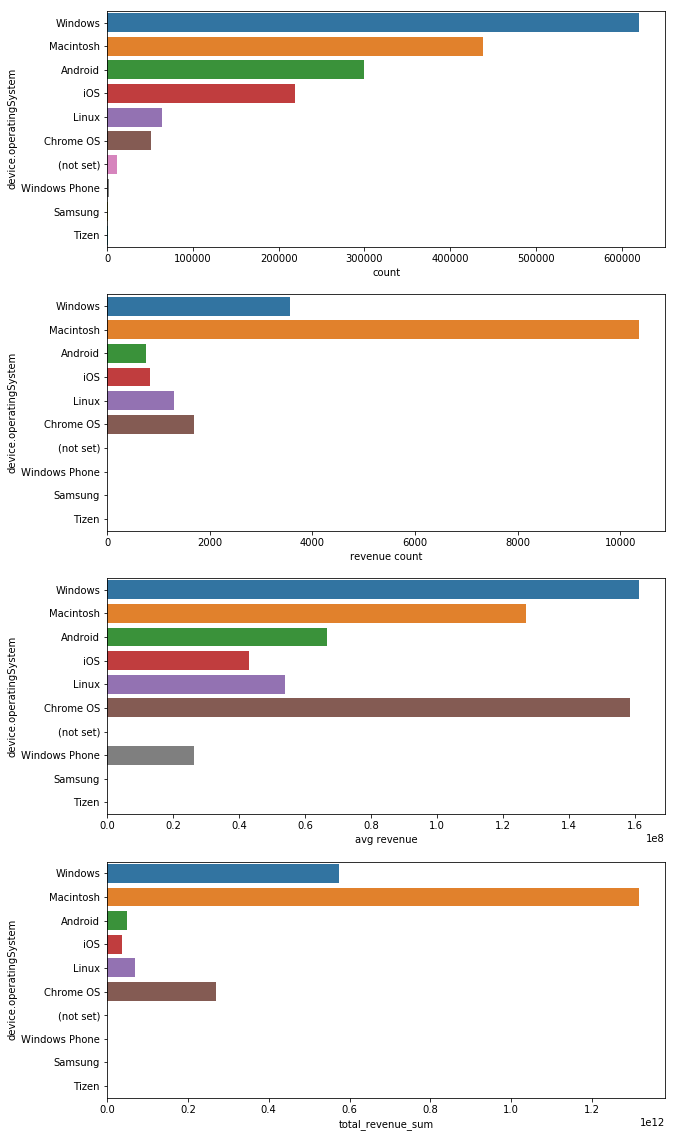

In [85]:
plt_categories(train_df, 'device.operatingSystem')

- <b> revenue generating users are more in macintosh
- users are more in windows
- avg revenue is more in chrome OS

### 4.9 Organic search

### 4.9.1 channel grouping

                  count  revenue count   avg revenue  total_revenue_sum
channelGrouping                                                        
Organic Search   738963           5513  9.785941e+07       5.394990e+11
Social           354971            161  4.576255e+07       7.367770e+09
Direct           273134           3320  1.799170e+08       5.973243e+11
Referral         211307           8586  1.160052e+08       9.960210e+11
Display           51283            205  5.282403e+08       1.082893e+11
Paid Search       45627            711  9.418934e+07       6.696862e+10
Affiliates        32915             17  5.088647e+07       8.650700e+08
(Other)             137              1  9.990000e+06       9.990000e+06
**************************************************


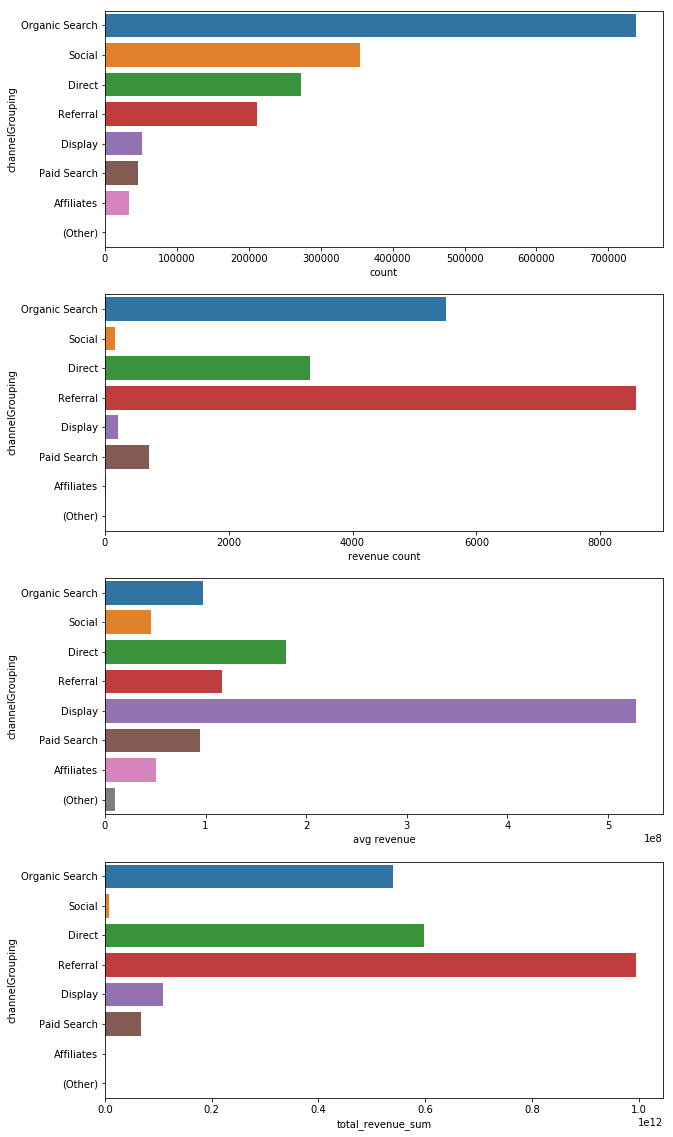

In [59]:
plt_categories(train_df, 'channelGrouping')

- <b> Organic Search, referral, Direct are the main source of revenue generation


### 5.0 PREPARING TRAIN DATASET

### correct dtype

In [40]:
train_df['totals.hits'] = train_df['totals.hits'].astype(float)
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype(float)
train_df['totals.timeOnSite'] = train_df['totals.timeOnSite'].astype(float)
train_df['totals.transactions'] = train_df['totals.transactions'].astype(float)
train_df['device.isMobile'] = train_df['device.isMobile'].astype(bool)
train_df['trafficSource.isTrueDirect'] = train_df['trafficSource.isTrueDirect'].astype(bool)


test_df['totals.hits'] = test_df['totals.hits'].astype(float)
test_df['totals.pageviews'] = test_df['totals.pageviews'].astype(float)
test_df['totals.timeOnSite'] = test_df['totals.timeOnSite'].astype(float)
test_df['totals.transactions'] = test_df['totals.transactions'].astype(float)
test_df['device.isMobile'] =test_df['device.isMobile'].astype(bool)
testdf['trafficSource.isTrueDirect'] = test_df['trafficSource.isTrueDirect'].astype(bool)

NameError: name 'testdf' is not defined

### preparing train data and feature engineering

In [41]:

#replace all empty fields with NaN
Nulls = ['(not set)', 'not available in demo dataset', '(not provided)', 
         'unknown.unknown', '/', 'Not Socially Engaged']
for null in Nulls:    
    train_df.replace(null, np.nan, inplace=True)
    test_df.replace(null,np.nan, inplace = True)

###  5.1 SIMPLE FEATURE ENGINEERING

###  5.1.1 timeframe window feature creation using traindata 

- below code in simple terms = 
- we have to predict given the test set of 168 days after a gap of 46 days for a period of 62 days what will be the revenue generated by each customer so we convert our train data 
- to 4 windows for each window we calculate the features then we calculate the target for the corresponding 62 days for each window that is how we generate our target, we first check if a customer is returnng in the 62 day window.
- if returning we calculate the target if not the target for that visitor will be zero.

In [11]:
# source code:- https://www.kaggle.com/kostoglot/winning-solution
from datetime import datetime, timedelta

# this function is to create dataframe of fixed time-interval of 168 days
# so we will create 4 windows of non overlapping dataframe 
#we have test data of 168 days and then a gap of 46 days and then we have the prediction month from 1 dec 2018 to 31 jan 2019 that is of 62 days
# so we use our train data to create 4 non overlapping windows of 168 days each and predict target for this window after a gap of 46 days for 62 day time period

def Timeframewithfeatures(tr_df, k):
    tf = tr_df.loc[(tr_df['date'] >= min(tr_df['date']) + timedelta(days = 168*(k-1))) 
               & (tr_df['date'] < min(tr_df['date']) + timedelta(days = 168*k))] # here we are taking dataframe of 168 days depending on k value
    
    tf_fvid = set(tr_df.loc[(tr_df['date'] >= min(tr_df['date']) +  timedelta(days = 168*k + 46)) 
                           & (tr_df['date'] < min(tr_df['date']) +  timedelta(days = 168*k + 46 +62))]['fullVisitorId']) # here we are getting the full visitor ids of the people who have shopped in the particular window have returned to the store after 46 days gap in 62 days interval
    
    tf_returned =  tr_df[tr_df['fullVisitorId'].isin(tf_fvid)] #this is the dataframe of the users in the window who have visited again afer the gap
    
    tf_tst = tr_df[tr_df['fullVisitorId'].isin(set(tf_returned['fullVisitorId']))
             & (tr_df['date'] >= min(tr_df['date']) + timedelta(days=168*k + 46))
             & (tr_df['date'] < min(tr_df['date']) + timedelta(days=168*k + 46 + 62))]    #making sure that this is in the same time window
    
    tf_target = tf_tst.groupby('fullVisitorId')['totals.transactionRevenue'].sum().apply(lambda x : np.log1p(x)).reset_index() #we are calculating target in the 62 day range after a gap of 46 days for each window
    tf_target['ret'] = 1 #creating new column with ret = 1 here giving a value of 1 for returning customers or users.
    tf_target.rename(columns={'totals.transactionRevenue': 'target'}, inplace=True)
    
    tf_nonret = pd.DataFrame() #similarly getting datframe for non returning customers
    tf_nonret['fullVisitorId'] = list(set(tf['fullVisitorId']) - tf_fvid)    #getting df for no return customer
    tf_nonret['target'] = 0 #if not returning the target is zero
    tf_nonret['ret'] = 0 #for non returning customer we create a column with zero as value which indicates the non returning of the customer
    
    tf_target = pd.concat([tf_target, tf_nonret], axis=0).reset_index(drop=True)
    # len(set(tf['fullVisitorId'])), len(set(tf_target['fullVisitorId']))
    tf_maxdate = max(tf['date'])
    tf_mindate = min(tf['date'])

    #generating new features 
    tf = tf.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': {'networkDomain': lambda x: x.dropna().max()},# for categorical column max function will take the max no. og occurance of that particaular category when grouped by full 
            'geoNetwork.city': {'city': lambda x: x.dropna().max()},
            'device.operatingSystem': {'operatingSystem': lambda x: x.dropna().max()},
            'geoNetwork.metro': {'metro': lambda x: x.dropna().max()},
            'geoNetwork.region': {'region': lambda x: x.dropna().max()},
            'channelGrouping': {'channelGrouping': lambda x: x.dropna().max()},
            'trafficSource.referralPath': {'referralPath': lambda x: x.dropna().max()},
            'geoNetwork.country': {'country': lambda x: x.dropna().max()},
            'trafficSource.source': {'source': lambda x: x.dropna().max()},
            'trafficSource.medium': {'medium': lambda x: x.dropna().max()},
            'trafficSource.keyword': {'keyword': lambda x: x.dropna().max()},
            'device.browser':  {'browser': lambda x: x.dropna().max()},
            'trafficSource.adwordsClickInfo.gclId': {'gclId': lambda x: x.dropna().max()},
            'device.deviceCategory': {'deviceCategory': lambda x: x.dropna().max()},
            'geoNetwork.continent': {'continent': lambda x: x.dropna().max()}, #which contitnent category occurs max time for that user
            'totals.timeOnSite': {'timeOnSite_sum': lambda x: x.dropna().sum(),#total time spent on site
                                  'timeOnSite_min': lambda x: x.dropna().min(), #min time spent on site
                                  'timeOnSite_max': lambda x: x.dropna().max(), # max time spent on site
                                  'timeOnSite_mean': lambda x: x.dropna().mean()}, #mean time spent on site
            'totals.pageviews': {'pageviews_sum': lambda x: x.dropna().sum(), #getting toal number of pageviews for each visitor
                                 'pageviews_min': lambda x: x.dropna().min(), #getting min number of pageviews for each visitor
                                 'pageviews_max': lambda x: x.dropna().max(), #getting max number of pageviews for each visitor
                                 'pageviews_mean': lambda x: x.dropna().mean()},
            'totals.hits': {'hits_sum': lambda x: x.dropna().sum(),  
                            'hits_min': lambda x: x.dropna().min(), 
                            'hits_max': lambda x: x.dropna().max(), 
                            'hits_mean': lambda x: x.dropna().mean()},
            'visitStartTime': {'visitStartTime_counts': lambda x: x.dropna().count()}, #number of times a visitor has visited the site
            'totals.sessionQualityDim': {'sessionQualityDim': lambda x: x.dropna().max()}, 
            'trafficSource.isTrueDirect': {'isTrueDirect': lambda x: x.dropna().max()},
            'device.isMobile': {'isMobile': lambda x: x.dropna().max()},
            'visitNumber': {'visitNumber_max' : lambda x: x.dropna().max()}, 
            'totals.transactionRevenue':  {'transactionRevenue_sum':  lambda x:x.dropna().sum()},
            'totals.transactions' : {'transactions' : lambda x:x.dropna().sum()},
            'date': {'first_ses_from_the_period_start': lambda x: x.dropna().min() - tf_mindate, #time of the first session start from the window strat
                     'last_ses_from_the_period_end': lambda x: tf_maxdate - x.dropna().max(), # gives last session from window end of user 
                     'interval_dates': lambda x: x.max() - x.min()} #time between first and last session of the user
                    })
    
    tf.columns = tf.columns.droplevel()

    tf = pd.merge(tf, tf_target, left_on='fullVisitorId', right_on='fullVisitorId')# merging target dataframe with feature dataframe
    return tf    
    


### saving the train data windows 

In [12]:
#extracting parts of traina nd storing in pickle file
# import pickle
# tr1_correct = Timeframewithfeatures(train_df, k = 1)
# tr1_correct.to_pickle('tr1_correct')
# print('1st part complete')


# tr2_correct = Timeframewithfeatures(train_df, k = 2)
# tr2_correct.to_pickle('tr2_correct')
# print('2nd part complete')

# tr3_correct = Timeframewithfeatures(train_df, k = 3)
# tr3_correct.to_pickle('tr3_correct')
# print('3rd part complete')


# tr4_correct = Timeframewithfeatures(train_df, k = 4)
# tr4_correct.to_pickle('tr4_correct')
# print('4th part complete')

4th part complete


### loading the train data windows

In [61]:
# ex = open('tr1_correct', 'rb')
# tr1 = pickle.load(ex)
# print(tr1.shape)

# ex1 = open('tr2_correct', 'rb')
# tr2 = pickle.load(ex1)
# print(tr2.shape)


# ex2 = open('tr3_correct', 'rb')
# tr3 = pickle.load(ex2)
# print(tr3.shape)

# ex3 = open('tr4_correct', 'rb')
# tr4 = pickle.load(ex3)
# print(tr4.shape)

(293194, 40)


In [24]:
### Construction of the test-set (by analogy as train-set)
print('Get test')
tr5 = test_df[test_df['date'] >= pd.to_datetime(20180501, infer_datetime_format=True, format="%Y%m%d")] #using test data to create train 5th window but we keep the target here as np.nan since we have to predict that, later we will seperate this out
tr5_maxdate = max(tr5['date'])
tr5_mindate = min(tr5['date'])

Get test


### 5.2 preparing test data features

In [25]:
#calculating the features for test
tr5 = tr5.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': {'networkDomain': lambda x: x.dropna().max()}, # for categorical column max function will take the max no. og occurance of that particaular category when grouped by full visitor id
            'geoNetwork.city': {'city': lambda x: x.dropna().max()}, #takes max number of occurance of city , alternatively to check use value_counts( function after groupby)
            'device.operatingSystem': {'operatingSystem': lambda x: x.dropna().max()},
            'geoNetwork.metro': {'metro': lambda x: x.dropna().max()},
            'geoNetwork.region': {'region': lambda x: x.dropna().max()},
            'channelGrouping': {'channelGrouping': lambda x: x.dropna().max()},
            'trafficSource.referralPath': {'referralPath': lambda x: x.dropna().max()},
            'geoNetwork.country': {'country': lambda x: x.dropna().max()},
            'trafficSource.source': {'source': lambda x: x.dropna().max()},
            'trafficSource.medium': {'medium': lambda x: x.dropna().max()},
            'trafficSource.keyword': {'keyword': lambda x: x.dropna().max()},
            'device.browser':  {'browser': lambda x: x.dropna().max()},
            'trafficSource.adwordsClickInfo.gclId': {'gclId': lambda x: x.dropna().max()},
            'device.deviceCategory': {'deviceCategory': lambda x: x.dropna().max()},
            'geoNetwork.continent': {'continent': lambda x: x.dropna().max()},
            'totals.timeOnSite': {'timeOnSite_sum': lambda x: x.dropna().sum(),
                                  'timeOnSite_min': lambda x: x.dropna().min(), 
                                  'timeOnSite_max': lambda x: x.dropna().max(),
                                  'timeOnSite_mean': lambda x: x.dropna().mean()},
            'totals.pageviews': {'pageviews_sum': lambda x: x.dropna().sum(),
                                 'pageviews_min': lambda x: x.dropna().min(), 
                                 'pageviews_max': lambda x: x.dropna().max(),
                                 'pageviews_mean': lambda x: x.dropna().mean()},
            'totals.hits': {'hits_sum': lambda x: x.dropna().sum(), 
                            'hits_min': lambda x: x.dropna().min(), 
                            'hits_max': lambda x: x.dropna().max(), 
                            'hits_mean': lambda x: x.dropna().mean()},
            'visitStartTime': {'visitStartTime_counts': lambda x: x.dropna().count()},# how many times has the cutomer visited in this window
            'totals.sessionQualityDim': {'sessionQualityDim': lambda x: x.dropna().max()},
            'device.isMobile': {'isMobile': lambda x: x.dropna().max()},
            'visitNumber': {'visitNumber_max' : lambda x: x.dropna().max()}, 
            'totals.transactionRevenue':  {'transactionRevenue_sum':  lambda x:x.dropna().sum()},
            'totals.transactions' : {'transactions' : lambda x:x.dropna().sum()},
            'date': {'first_ses_from_the_period_start': lambda x: x.dropna().min() - tr5_mindate,
                     'last_ses_from_the_period_end': lambda x: tr5_maxdate - x.dropna().max(),
                     'interval_dates': lambda x: x.dropna().max() - x.dropna().min(),
                     },
                    })
tr5.columns = tr5.columns.droplevel()
tr5['target'] = np.nan #becomes easy to seperate train and test data later
tr5['ret'] = np.nan

In [26]:
#save the file
#tr5.to_pickle('tr5_correct')

In [5]:
#tr5.to_pickle('tr5_')
ex5 = open('tr5_correct', 'rb')
tr5 = pickle.load(ex5)
print(tr5.shape)

(296530, 38)


In [8]:
tr5 = tr5.reset_index()

In [15]:
tr55 = tr5[['fullVisitorId', 'channelGrouping', 'transactionRevenue_sum',
       'transactions', 'visitNumber_max', 'isMobile', 'hits_max', 'hits_sum',
       'hits_min', 'hits_mean', 'sessionQualityDim', 'visitStartTime_counts',
       'deviceCategory', 'country', 'browser', 'timeOnSite_mean',
       'timeOnSite_max', 'timeOnSite_min', 'timeOnSite_sum',
       'last_ses_from_the_period_end', 'first_ses_from_the_period_start',
       'interval_dates', 'region', 'referralPath', 'medium', 'keyword', 'city',
       'operatingSystem', 'gclId', 'networkDomain', 'pageviews_min',
       'pageviews_max', 'pageviews_mean', 'pageviews_sum', 'metro', 'source',
       'continent', 'target', 'ret']]

tr55.columns

Index(['fullVisitorId', 'channelGrouping', 'transactionRevenue_sum',
       'transactions', 'visitNumber_max', 'isMobile', 'hits_max', 'hits_sum',
       'hits_min', 'hits_mean', 'sessionQualityDim', 'visitStartTime_counts',
       'deviceCategory', 'country', 'browser', 'timeOnSite_mean',
       'timeOnSite_max', 'timeOnSite_min', 'timeOnSite_sum',
       'last_ses_from_the_period_end', 'first_ses_from_the_period_start',
       'interval_dates', 'region', 'referralPath', 'medium', 'keyword', 'city',
       'operatingSystem', 'gclId', 'networkDomain', 'pageviews_min',
       'pageviews_max', 'pageviews_mean', 'pageviews_sum', 'metro', 'source',
       'continent', 'target', 'ret'],
      dtype='object')

### 5.3 combining all the windows

In [16]:
train = pd.concat([tr1, tr2, tr3, tr4, tr55], axis=0, sort=False).reset_index(drop=True)
train['interval_dates'] = train['interval_dates'].dt.days
train['first_ses_from_the_period_start'] = train['first_ses_from_the_period_start'].dt.days
train['last_ses_from_the_period_end'] = train['last_ses_from_the_period_end'].dt.days

In [145]:
ex7 = open('final_train_correct', 'rb')
final_train = pickle.load(ex7)

### 5.4 filtering train and test data from combined dataset

In [146]:
#test data
test = final_train[final_train['target'].isnull()] #seperating the test from the final dataset
test

,fullVisitorId,channelGrouping,transactionRevenue_sum,transactions,visitNumber_max,isMobile,hits_max,hits_sum,hits_min,hits_mean,...,networkDomain,pageviews_min,pageviews_max,pageviews_mean,pageviews_sum,metro,source,continent,target,ret
1344567,0000018966949534117,Organic Search,0,0,1,False,7,7,7,7.0,...,(not set),7,7,7.0,7,San Francisco-Oakland-San Jose CA,google,Americas,NaN,NaN
1344568,0000039738481224681,Direct,0,0,1,True,1,1,1,1.0,...,(not set),1,1,1.0,1,not available in demo dataset,(direct),Americas,NaN,NaN
1344569,0000073585230191399,Organic Search,0,0,1,True,1,1,1,1.0,...,(not set),1,1,1.0,1,not available in demo dataset,google,Americas,NaN,NaN
1344570,0000087588448856385,Organic Search,0,0,1,False,1,1,1,1.0,...,tku.edu.tw,1,1,1.0,1,not available in demo dataset,google,Asia,NaN,NaN
1344571,0000149787903119437,Organic Search,0,0,1,True,1,1,1,1.0,...,telekom.rs,1,1,1.0,1,not available in demo dataset,google,Europe,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641092,9999862054614696520,Organic Search,0,0,1,False,15,15,15,15.0,...,actcorp.in,12,12,12.0,12,(not set),google,Asia,NaN,NaN
1641093,9999898168621645223,Organic Search,0,0,1,True,3,3,3,3.0,...,bellmts.net,3,3,3.0,3,not available in demo dataset,google,Americas,NaN,NaN
1641094,999990167740728398,Direct,0,0,1,True,1,1,1,1.0,...,vodafone.in,1,1,1.0,1,(not set),(direct),Asia,NaN,NaN
1641095,9999915620249883537,Organic Search,0,0,1,False,9,9,9,9.0,...,(not set),7,7,7.0,7,San Francisco-Oakland-San Jose CA,yahoo,Americas,NaN,NaN


In [147]:
#train data
train = final_train[final_train['target'].notnull()]
train

,fullVisitorId,channelGrouping,transactionRevenue_sum,transactions,visitNumber_max,isMobile,hits_max,hits_sum,hits_min,hits_mean,...,networkDomain,pageviews_min,pageviews_max,pageviews_mean,pageviews_sum,metro,source,continent,target,ret
0,0000010278554503158,Organic Search,0,0,1,False,11,11,11,11.0,...,xtra.co.nz,8,8,8.0,8,NaN,google,Oceania,0.0,0.0
1,0000020424342248747,Organic Search,0,0,1,False,17,17,17,17.0,...,munitrujillo.gob.pe,13,13,13.0,13,NaN,(direct),Americas,0.0,0.0
2,000005103959234087,Organic Search,0,0,1,True,10,10,10,10.0,...,comcast.net,8,8,8.0,8,NaN,google,Americas,0.0,0.0
3,0000093957001069502,Organic Search,0,0,1,False,2,2,2,2.0,...,NaN,2,2,2.0,2,NaN,(direct),Americas,0.0,0.0
4,0000114156543135683,Social,0,0,1,False,1,1,1,1.0,...,ttnet.com.tr,1,1,1.0,1,NaN,youtube.com,Asia,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344562,9999818112872622034,Direct,0,0,1,True,48,48,48,48.0,...,NaN,29,29,29.0,29,NaN,(direct),Americas,0.0,0.0
1344563,9999882818693474736,Referral,8.636e+07,1,1,False,61,61,61,61.0,...,verizon.net,39,39,39.0,39,New York NY,(direct),Americas,0.0,0.0
1344564,9999941518946450908,Organic Search,0,0,1,False,1,1,1,1.0,...,telekom.at,1,1,1.0,1,NaN,google,Europe,0.0,0.0
1344565,9999969142283897422,Organic Search,0,0,1,False,6,6,6,6.0,...,NaN,6,6,6.0,6,NaN,google,Americas,0.0,0.0


- Procedure:-
    - we will follow the standard procedure to encode the train and test data
    - seperately take categorical columns from numerical columns
    - label encoding for cat colmuns 
    - normalizing numerical columns
    - before that fill the missing values in the dataset

In [148]:
target_cols = ['target', 'ret', 'transactionRevenue_sum', 'fullVisitorId']
target_test = test['transactionRevenue_sum'].astype('float').apply(lambda x: np.log1p(x))

In [149]:
# train data 
train_x = train.drop(target_cols, axis = 1)
train_x_id = train['fullVisitorId'].astype('str')
train_y = train['target']
train_ret = train['ret']

test_x = test.drop(target_cols, axis = 1)
test_x_id = test['fullVisitorId'].astype('str')
test_y = target_test
test_ret = test['ret']

In [150]:
#correct dtype train

train_x['transactions'] = train_x['transactions'].astype('float')
train_x['hits_max'] = train_x['hits_max'].astype('float')
train_x['hits_sum'] = train_x['hits_sum'].astype('float')
train_x['hits_min'] = train_x['hits_min'].astype('float')
train_x['timeOnSite_max'] = train_x['timeOnSite_max'].astype('float')
train_x['timeOnSite_min'] = train_x['timeOnSite_min'].astype('float')
train_x['timeOnSite_sum'] = train_x['timeOnSite_sum'].astype('float')
train_x['pageviews_min'] = train_x['pageviews_min'].astype('float')
train_x['pageviews_max'] = train_x['pageviews_max'].astype('float')
train_x['pageviews_sum'] = train_x['pageviews_sum'].astype('float')
train_x['isMobile'] = train_x['isMobile'].astype('object')

#correct dtype test

test_x['transactions'] = test_x['transactions'].astype('float')
test_x['hits_max'] = test_x['hits_max'].astype('float')
test_x['hits_sum'] = test_x['hits_sum'].astype('float')
test_x['hits_min'] = test_x['hits_min'].astype('float')
test_x['timeOnSite_max'] = test_x['timeOnSite_max'].astype('float')
test_x['timeOnSite_min'] = test_x['timeOnSite_min'].astype('float')
test_x['timeOnSite_sum'] = test_x['timeOnSite_sum'].astype('float')
test_x['pageviews_min'] = test_x['pageviews_min'].astype('float')
test_x['pageviews_max'] = test_x['pageviews_max'].astype('float')
test_x['pageviews_sum'] = test_x['pageviews_sum'].astype('float')
test_x['isMobile'] = test_x['isMobile'].astype('object')

In [151]:
#taking cat and numerical columns seperately
cat_cols = [x for x in train_x.columns if train_x[x].dtype == 'object']
num_cols = set(train_x.columns) - set(cat_cols)

In [152]:
print(num_cols)
print('\n')
print(cat_cols)

{'interval_dates', 'hits_max', 'timeOnSite_mean', 'pageviews_mean', 'first_ses_from_the_period_start', 'pageviews_max', 'visitNumber_max', 'timeOnSite_min', 'last_ses_from_the_period_end', 'hits_mean', 'hits_min', 'hits_sum', 'timeOnSite_sum', 'timeOnSite_max', 'pageviews_sum', 'visitStartTime_counts', 'transactions', 'pageviews_min'}


['channelGrouping', 'isMobile', 'sessionQualityDim', 'deviceCategory', 'country', 'browser', 'region', 'referralPath', 'medium', 'keyword', 'city', 'operatingSystem', 'gclId', 'networkDomain', 'metro', 'source', 'continent']


In [153]:
# fill missing in train
for col in cat_cols:
    train_x[col].fillna('missing', inplace=True) 
    test_x[col].fillna('missing', inplace=True)

for col in num_cols:       
    train_x[col].fillna(0, inplace=True)
    test_x[col].fillna(0, inplace=True)

In [57]:
train_x_copy = train_x.copy()
test_x_copy = test_x.copy()

### 5.5 label encoding for categorical features

In [154]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_x[col],test_x[col]]).astype("str"))
    train_x[col] = lbe.transform(train_x[col].astype("str"))
    test_x[col] = lbe.transform(test_x[col].astype("str"))

transform column channelGrouping
transform column isMobile
transform column sessionQualityDim
transform column deviceCategory
transform column country
transform column browser
transform column region
transform column referralPath
transform column medium
transform column keyword
transform column city
transform column operatingSystem
transform column gclId
transform column networkDomain
transform column metro
transform column source
transform column continent


### 5.6 normalizing numerical features

In [155]:
from sklearn.preprocessing import StandardScaler
for col in num_cols:
    norm = StandardScaler()
    norm.fit(train_x[col].values.reshape(-1,1))
    train_x[col] = norm.transform(train_x[col].values.reshape(-1,1))
    test_x[col] = norm.transform(test_x[col].values.reshape(-1,1))


In [ ]:
train_x

In [15]:
#saving train  and test files
# train_x.to_pickle('train_x')
# test_x.to_pickle('test_x')
# train_y.to_pickle('train_y')
# test_y.to_pickle('test_y')

### 5.6.1 load train_x and test_x here 

In [2]:
## loading testx and train x
x = open('train_x', 'rb')
train_x = pickle.load(x)

x1 = open('test_x', 'rb')
test_x = pickle.load(x1)

x2 = open('train_y', 'rb')
train_y = pickle.load(x2)

x3 = open('test_y', 'rb')
test_y = pickle.load(x3)


## 6.0 Machione learning models

### 6.1 LIGHT gbm

In [18]:
#lets specify thr parametrs first
import lightgbm as lgb
params1 = {'task': 'train',
          'num_iterations': 30, #no of boost round or number of estimators 
         'boosting':'gbdt', #gradient boosted decision tree
         'objective' : 'regression',
          'metric': ['rmse'], #roort mean suqre error
          'is_training_metric': True, #return metric on train data
          'learning_rate' :0.01,
          'max_leaves': 1000,
          'feature_fraction': 0.8, #col sampling
          'bagging_fraction': 0.8, 
          'colsample_bytree': 1.0,
          'max_depth':20, 
          'min_child_samples': 100,
          'reg_alpha': 1, 
          'reg_lambda': 1}

#create train data 
dtrain1 = lgb.Dataset(data = train_x, label = list(train_y.values)) 

#training 
model = lgb.train(params1, dtrain1) 
cv = lgb.cv(params1, dtrain1, nfold= 5, stratified=False, metrics = 'rmse', eval_train_metric= True)
#predicting

pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

In [19]:
cv

{'train rmse-mean': [0.3107062730722925,
  0.3105743918816944,
  0.310450825856751,
  0.3103397102633879,
  0.310218383680479,
  0.310096403714567,
  0.3099783607930632,
  0.3098677762805099,
  0.309756973371474,
  0.3096430880479333,
  0.3095324364865534,
  0.30941978803668135,
  0.3093204796678434,
  0.30921409186998217,
  0.3091052182645713,
  0.3090099022340679,
  0.3089082700094919,
  0.30880370152295394,
  0.3087045565592482,
  0.30860234491477395,
  0.30849923063227563,
  0.3084011220034967,
  0.3083008560324576,
  0.3081987845160167,
  0.3081000323552671,
  0.30800754670847647,
  0.3079074457055499,
  0.30781528521665696,
  0.30771456264455777,
  0.3076315552156471],
 'train rmse-stdv': [0.0020275477961546216,
  0.002024447344714125,
  0.002023715842914608,
  0.002020512748396006,
  0.0020185702399703213,
  0.002019062309922428,
  0.002017727003487168,
  0.002016368703233064,
  0.0020175502702885198,
  0.0020184004904099636,
  0.002021250400498955,
  0.0020207685207788684,
  0.

In [ ]:
## saving model
#model.save_model('lgbm_model.txt')
bst = lgb.Booster(model_file='lgbm_model.txt')#load model

### Plotting Feature Importances:-

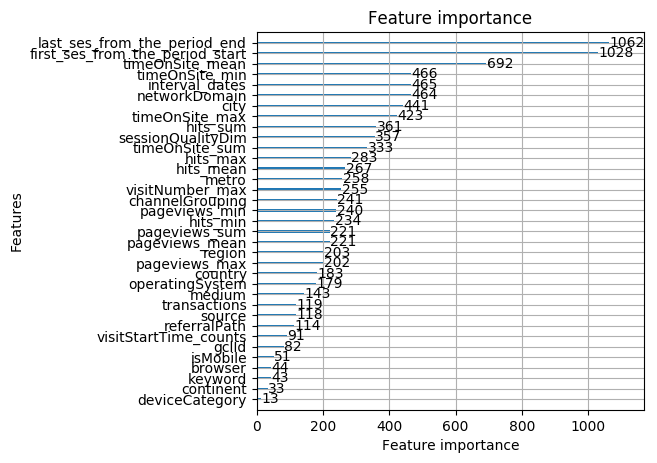

In [24]:
bst = lgb.Booster(model_file = 'lgbm_model.txt')
lgb.plot_importance(bst, importance_type= 'split',figsize= (5,5), dpi = 100)
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(train_y.values, pred_train)
print('train_rmse',np.sqrt(train_mse))

test_mse = mean_squared_error(test_y.values, pred_test)
print('LeaderBoard score = 0.88501')

train_rmse 0.3072350243688694
LeaderBoard score = 0.88501


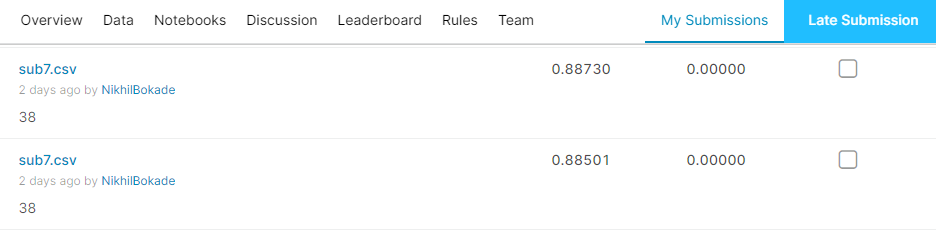

### saving the output file

In [97]:
x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': pred_test})
x.to_csv('sub7.csv', index = False)

### 6.2 XGBoost

In [16]:
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
model = xgb.XGBRegressor() 

# #train_data
# dtrain = xgb.DMatrix(data = train_x, label = train_y)
# dtest = xgb.DMatrix(data = test_x)

# best parameters
param = {'max_depth': [3, 5,10,12],
         'n_estimators': [80,120,250,500],
         'learning_rate' : [0.001, 0.01, 0.15,0.2,0.5],
        'colsample_bytree' : [0.6]}


#training process
random_search = RandomizedSearchCV(model, param_distributions=param, cv = 5,scoring='neg_root_mean_squared_error', n_iter=3, refit= True)
random_search.fit(train_x, train_y)
print(random_search.best_estimator_)
print(random_search.best_score_)
random_search.cv_results_

[03:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:54:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:01:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:08:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'mean_fit_time': array([ 418.90012789, 2482.68401151,  130.59483685]),
 'mean_score_time': array([ 2.12291083, 15.18359814,  0.68761406]),
 'mean_test_score': array([-0.29483939, -0.42576559, -0.53529629]),
 'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.2, 0.001, 0.001],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 12, 3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[250, 500, 120],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 0.6,
   'learning_rate': 0.2,
   'max_depth': 5,
   'n_estimators': 250},
  {'colsample_bytree': 0.6,
   'learning_rate': 0.001,
   'max_depth': 12,
 

In [24]:
#refitting the model with best hyperparameters
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1).fit(train_x, train_y)

[08:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
#saving model
model.save_model('modelxgboost')
print('LB score = 2.0947 for xgboost model')

LB score = 2.0947 for xgboost model


In [29]:
### saving the output file:
x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': test_pred})
x.to_csv('sub8.csv', index = False)

### 6.3 STACKING REGRESSOR

In [157]:
train_norm = (train_x.values - train_x.values.min(axis = 0))/(train_x.values.max(axis = 0) - train_x.values.min(axis = 0))
test_norm = (test_x.values - test_x.values.min(axis = 0))/(test_x.values.max(axis = 0) - test_x.values.min(axis = 0))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from mlxtend.regressor import StackingRegressor

rg2 = SGDRegressor(alpha= 0.01)
rg3 = ExtraTreesRegressor(n_estimators= 80, n_jobs= -1)
rg4 = AdaBoostRegressor(learning_rate= 0.001)
rg_final = StackingRegressor(regressors = [rg2, rg4], meta_regressor= rg3)
stacking_model = rg_final.fit(train_norm, train_y.values)

In [62]:
pred_train = stacking_model.predict(train_norm)
from sklearn.metrics import mean_squared_error
print('train_rmse', np.sqrt(mean_squared_error(train_y.values, pred_train)))

train_rmse 0.08876143396315865


In [66]:
test_pred = stacking_model.predict(test_norm)
test_pred

array([0., 0., 0., ..., 0., 0., 0.])

### saving output file

In [68]:
x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': test_pred})
x.to_csv('sub9.csv', index = False)

In [69]:
print(' the leaderboard score using stacking regressor is', 0.90166)

 the leaderboard score using stacking regressor is 0.90166


## NEURAL NETWORK

### 7.0 Multilayer Perceptron (MLP)

In [226]:
import tensorflow
KERAS_BACKEND=tensorflow
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import seaborn as sns
from keras.initializers import he_normal, glorot_uniform
from keras.optimizers import Adam, adagrad
adam = Adam(learning_rate= 0.01, clipnorm = 1)
from keras.callbacks import ModelCheckpoint
filepath = 'model_weights.hdf5'
checkpoint1 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
##defining the arcgitecture
callbacks = [checkpoint1]
input_dim = 35
epochs = 20
batch_size = 1024

model = Sequential()
model.add(Dense(126, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (input_dim, ) ))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(1, activation = 'linear'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 126)               4536      
_________________________________________________________________
dropout_20 (Dropout)         (None, 126)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8128      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 65        
Total params: 12,729
Trainable params: 12,729
Non-trainable params: 0
_________________________________________________________________


In [227]:
#configure leaninh process
model.compile(optimizer= 'Adam', loss = 'mse', metrics = ['mse'])
#training model
history = model.fit(train_norm, train_y.values, batch_size, epochs,callbacks= callbacks, validation_data = (test_norm, test_y.values))

Train on 1344567 samples, validate on 296530 samples
Epoch 1/20
1344567/1344567 [==============================] - 37s 28us/step - loss: 0.1015 - mse: 0.1015 - val_loss: 6.7381 - val_mse: 6.7381

Epoch 00001: val_loss improved from inf to 6.73808, saving model to model_weights.hdf5
Epoch 2/20
1344567/1344567 [==============================] - 37s 28us/step - loss: 0.0960 - mse: 0.0960 - val_loss: 6.7128 - val_mse: 6.7128

Epoch 00002: val_loss improved from 6.73808 to 6.71283, saving model to model_weights.hdf5
Epoch 3/20
1344567/1344567 [==============================] - 48s 35us/step - loss: 0.0954 - mse: 0.0954 - val_loss: 6.7218 - val_mse: 6.7218

Epoch 00003: val_loss did not improve from 6.71283
Epoch 4/20
1344567/1344567 [==============================] - 37s 28us/step - loss: 0.0949 - mse: 0.0949 - val_loss: 6.7289 - val_mse: 6.7289

Epoch 00004: val_loss did not improve from 6.71283
Epoch 5/20
1344567/1344567 [==============================] - 32s 24us/step - loss: 0.0947 - ms

In [228]:
from keras.models import load_model
model1 = load_model('model_weights.hdf5')
pred_test = model1.predict(test_norm)

In [229]:
pred_test = pred_test.flatten()
pred_test

array([0.01100639, 0.01069798, 0.0069023 , ..., 0.01050535, 0.00480799,
       0.00096843], dtype=float32)

In [230]:
x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': pred_test})
x.to_csv('sub9.csv', index = False)

In [231]:
print('the leaderboard score using multilayer perceptron is ', 0.88446)

the leaderboard score using multilayer perceptron is  0.88446


### RESULTS

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['model', ' train rmse score', 'LB Score']
x.add_row(['LGB regressor', '0.3072 ', '0.88501'])
x.add_row(['XGB Regressor', '0.294', '2.0947'])
x.add_row(['stacking classifier', '0.088', '0.9016'])
x.add_row(['Multilayer perceptron', '0.3026', '0.88446'])
print(x)
print('got best results using simple multilayer perceptron', 0.88446)

+-----------------------+-------------------+----------+
|         model         |  train rmse score | LB Score |
+-----------------------+-------------------+----------+
|     LGB regressor     |      0.3072       | 0.88501  |
|     XGB Regressor     |       0.294       |  2.0947  |
|  stacking classifier  |       0.088       |  0.9016  |
| Multilayer perceptron |       0.3026      | 0.88446  |
+-----------------------+-------------------+----------+
got best results using simple multilayer perceptron 0.88446


In [5]:
print('**************************************************** END *****************************************************')

**************************************************** END *****************************************************
